# Correlogram Analysis

This notebook analyzes the results from correlogram experiments.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Define problem ordering
problem_ordering = [
    'OneMax', 
    #'HelloWorld', 
    # 'Sphere',
    #'TSP', 
    #'NeuralNetwork',
    'BFS-CNF1',
    'BFS-CNF2',
    'BFS-CNF3',
    'BFS-CNF4',
    'BFS-CNF5',
    #'BFS-Full', 
    #'BFS-EvenParity',
    #'GrammaticalEvolution', 
    ]

## 1. Summary Statistics from Main Results

Read the main CSV results file and create a grouped summary table.

In [282]:
# Read main results files - now we have multiple reps
df0 = pd.read_csv('outputs/results_2026_01_26_correlogram_rep0.csv')
df1_4 = pd.read_csv('outputs/results_2026_01_26_correlogram_rep1_4.csv')
df5_9 = pd.read_csv('outputs/results_2026_01_26_correlogram_rep5_9.csv')
df10 = pd.read_csv('outputs/results_2026_01_26_correlogram_rep10.csv')
df11_19 = pd.read_csv('outputs/results_2026_01_26_correlogram_rep11_19.csv')

# Combine all reps
df = pd.concat([df0, df1_4, df5_9, df10, df11_19], ignore_index=True)

print(f"Total rows: {len(df)}")
print(f"Unique reps: {sorted(df['rep'].unique())}")

df['avg_dist'] = df['diameter'] / 2.0
df['norm_corr_length'] = df['cor_length'] / df['avg_dist']
df.head()

Total rows: 720
Unique reps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


,Unnamed: 0,problem,size,size_cat,solver,budget,dist_type,name_type,generator,rep,...,onestep_cor,diameter,sr_structural_change_cor,sr_average_parent_length,g_avg_dist,g_total_var,g_norm_corr_length,g_nugget,avg_dist,norm_corr_length
0,0,OneMax,10,small,correlogram,10000,coarse,lin,one-max,0,...,0.644530,9.94,0.0,0.0,4.980751,2.115591,2.007729,0,4.97,0.982110
1,1,OneMax,10,small,correlogram,10000,coarse,str,one-max,0,...,0.644530,9.94,0.0,0.0,4.980751,2.115591,2.007729,0,4.97,0.982110
2,2,OneMax,50,medium,correlogram,50000,coarse,lin,one-max,0,...,0.782349,50.40,0.0,0.0,24.571822,15.224975,1.627881,0,25.20,0.825188
3,3,OneMax,50,medium,correlogram,50000,coarse,str,one-max,0,...,0.782349,50.40,0.0,0.0,24.571822,15.224975,1.627881,0,25.20,0.825188
4,4,OneMax,100,large,correlogram,200000,coarse,lin,one-max,0,...,0.724333,100.30,0.0,0.0,49.078176,17.589975,1.344707,0,50.15,0.415143


In [283]:
df.columns

Index(['Unnamed: 0', 'problem', 'size', 'size_cat', 'solver', 'budget',
       'dist_type', 'name_type', 'generator', 'rep', 'elapsed', 'cor_length',
       'onestep_cor', 'diameter', 'sr_structural_change_cor',
       'sr_average_parent_length', 'g_avg_dist', 'g_total_var',
       'g_norm_corr_length', 'g_nugget', 'avg_dist', 'norm_corr_length'],
      dtype='object')

In [284]:
# Create groupby table across problem / size / dist_type / name_type
# Note: The main results file should have columns for diameter, cor_length, and onestep_cor
# If there are multiple reps, we'll aggregate (mean)

groupby_cols = ['problem', 'size', 'name_type', 'generator']

summary_cols = ['avg_dist', 'cor_length', 'onestep_cor', 'sr_structural_change_cor', 'sr_average_parent_length',
                'g_avg_dist', 'g_total_var', 'g_norm_corr_length', 'g_nugget']

summary_table = df.groupby(groupby_cols)[summary_cols].mean()

# Apply problem ordering
summary_table = summary_table.reset_index()
summary_table['problem'] = pd.Categorical(summary_table['problem'], categories=problem_ordering, ordered=True)
summary_table = summary_table.sort_values(['problem', 'size', 'name_type'])
summary_table = summary_table.set_index(groupby_cols)

summary_table

avg_dist  cor_length  onestep_cor  \
problem  size name_type generator                                          
OneMax   10   lin       one-max        4.996417    4.904054     0.681987   
              str       one-max        4.996417    4.904054     0.681987   
         50   lin       one-max       25.055917   19.055697     0.732676   
              str       one-max       25.055917   19.055697     0.732676   
         100  lin       one-max       50.007592   18.903488     0.743429   
              str       one-max       50.007592   18.903488     0.743429   
BFS-CNF1 6    lin       sr-depth-gen  12.730658    2.151424     0.383524   
              str       sr-depth-gen  15.692374    1.907943     0.430041   
         12   lin       sr-depth-gen  20.072820    5.299752     0.415464   
              str       sr-depth-gen  25.466232    8.336680     0.474772   
         18   lin       sr-depth-gen  31.019622    8.426523     0.446763   
              str       sr-depth-gen  39.907518   10.429832     0.513852   
BFS-CNF2 6    lin       sr-depth-gen  12.730658    3.821357     0.382831   
              str       sr-depth-gen  15.692374    3.622409     0.429122   
         12   lin       sr-depth-gen  20.072820    6.438935     0.413115   
              str       sr-depth-gen  25.466232    7.899126     0.468581   
         18   lin       sr-depth-gen  31.019622    6.669377     0.455115   
              str       sr-depth-gen  39.907518   11.560834     0.504864   
BFS-CNF3 6    lin       sr-depth-gen  12.730658    2.805561     0.393250   
              str       sr-depth-gen  15.692374    2.919918     0.439277   
         12   lin       sr-depth-gen  20.072820    5.624885     0.422357   
              str       sr-depth-gen  25.466232    7.875169     0.467483   
         18   lin       sr-depth-gen  31.019622    6.968942     0.449040   
              str       sr-depth-gen  39.907518   12.426935     0.503795   
BFS-CNF4 8    lin       sr-depth-gen  12.816042    3.216586     0.393818   
              str       sr-depth-gen  15.764318    4.657634     0.431765   
         16   lin       sr-depth-gen  20.121585    6.977858     0.417659   
              str       sr-depth-gen  25.485902    8.021886     0.463104   
         20   lin       sr-depth-gen  30.648093    8.050063     0.456031   
              str       sr-depth-gen  39.515521   13.846862     0.492833   
BFS-CNF5 10   lin       sr-depth-gen  20.128563    5.053128     0.431763   
              str       sr-depth-gen  25.374513    7.774342     0.479654   
         15   lin       sr-depth-gen  20.104695    6.059021     0.420603   
              str       sr-depth-gen  25.184970    7.727934     0.464648   
         20   lin       sr-depth-gen  30.648093    7.882793     0.447734   
              str       sr-depth-gen  39.515521   11.538299     0.491809   

                                      sr_structural_change_cor  \
problem  size name_type generator                                
OneMax   10   lin       one-max                       0.000000   
              str       one-max                       0.000000   
         50   lin       one-max                       0.000000   
              str       one-max                       0.000000   
         100  lin       one-max                       0.000000   
              str       one-max                       0.000000   
BFS-CNF1 6    lin       sr-depth-gen                 -0.025859   
              str       sr-depth-gen                  0.159626   
         12   lin       sr-depth-gen                  0.020237   
              str       sr-depth-gen                  0.239201   
         18   lin       sr-depth-gen                  0.065820   
              str       sr-depth-gen                  0.331854   
BFS-CNF2 6    lin       sr-depth-gen                 -0.032462   
              str       sr-depth-gen                  0.142706   
         12   lin       sr-depth-gen                  0.014661   
              str       sr-d

In [285]:
# Save the summary table to CSV
summary_table.to_csv('outputs/correlogram_summary_table.csv')
print("Summary table saved to outputs/correlogram_summary_table.csv")

# Export to LaTeX
latex_str = summary_table.to_latex(float_format="%.3f")
with open('outputs/correlogram_summary_table.tex', 'w') as f:
    f.write(latex_str)
print("Summary table saved to outputs/correlogram_summary_table.tex")

Summary table saved to outputs/correlogram_summary_table.csv
Summary table saved to outputs/correlogram_summary_table.tex


In [286]:
# Group by problem, size, and name_type - aggregate across reps
groupby_cols = ['problem', 'size', 'name_type']
summary_cols = ['avg_dist', 'cor_length', 'norm_corr_length', 'onestep_cor', 'sr_structural_change_cor',
                'sr_average_parent_length', 'g_avg_dist', 'g_total_var',
                'g_norm_corr_length', 'g_nugget']

# Aggregate with mean and std across reps
agg_dict = {col: ['mean', 'std'] for col in summary_cols}
correlation_summary = df.groupby(groupby_cols).agg(agg_dict)

# Flatten column names
correlation_summary.columns = ['_'.join(col).strip() for col in correlation_summary.columns.values]

# Apply problem ordering
correlation_summary = correlation_summary.reset_index()
correlation_summary['problem'] = pd.Categorical(correlation_summary['problem'], categories=problem_ordering, ordered=True)
correlation_summary = correlation_summary.sort_values(['problem', 'size', 'name_type'])
correlation_summary = correlation_summary.set_index(groupby_cols)

correlation_summary

avg_dist_mean  avg_dist_std  cor_length_mean  \
problem  size name_type                                                 
OneMax   10   lin             4.996417      0.093334         4.904054   
              str             4.996417      0.093334         4.904054   
         50   lin            25.055917      0.192817        19.055697   
              str            25.055917      0.192817        19.055697   
         100  lin            50.007592      0.374678        18.903488   
              str            50.007592      0.374678        18.903488   
BFS-CNF1 6    lin            12.730658      0.341046         2.151424   
              str            15.692374      0.557039         1.907943   
         12   lin            20.072820      0.487400         5.299752   
              str            25.466232      0.629098         8.336680   
         18   lin            31.019622      0.735278         8.426523   
              str            39.907518      1.045901        10.429832   
BFS-CNF2 6    lin            12.730658      0.341046         3.821357   
              str            15.692374      0.557039         3.622409   
         12   lin            20.072820      0.487400         6.438935   
              str            25.466232      0.629098         7.899126   
         18   lin            31.019622      0.735278         6.669377   
              str            39.907518      1.045901        11.560834   
BFS-CNF3 6    lin            12.730658      0.341046         2.805561   
              str            15.692374      0.557039         2.919918   
         12   lin            20.072820      0.487400         5.624885   
              str            25.466232      0.629098         7.875169   
         18   lin            31.019622      0.735278         6.968942   
              str            39.907518      1.045901        12.426935   
BFS-CNF4 8    lin            12.816042      0.415017         3.216586   
              str            15.764318      0.445515         4.657634   
         16   lin            20.121585      0.482882         6.977858   
              str            25.485902      0.498568         8.021886   
         20   lin            30.648093      0.905845         8.050063   
              str            39.515521      1.006034        13.846862   
BFS-CNF5 10   lin            20.128563      0.374288         5.053128   
              str            25.374513      0.613489         7.774342   
         15   lin            20.104695      0.627360         6.059021   
              str            25.184970      0.798116         7.727934   
         20   lin            30.648093      0.905845         7.882793   
              str            39.515521      1.006034        11.538299   

                         cor_length_std  norm_corr_length_mean  \
problem  size name_type                                          
OneMax   10   lin              0.071401               0.981825   
              str              0.071401               0.981825   
         50   lin              3.594007               0.760856   
              str              3.594007               0.760856   
         100  lin              3.548292               0.377804   
              str              3.548292               0.377804   
BFS-CNF1 6    lin              0.508474               0.168740   
              str              0.045661               0.121745   
         12   lin              1.927222               0.263948   
              str              3.746280               0.328092   
         18   lin              3.420750               0.272706   
              str              3.892561               0.261617   
BFS-CNF2 6    lin              1.310196               0.300179   
              str              2.081781               0.230365   
         12   lin              1.644343               0.320293   
              str              2.517682               0.310319   
         18   lin              1.535521               0.215011

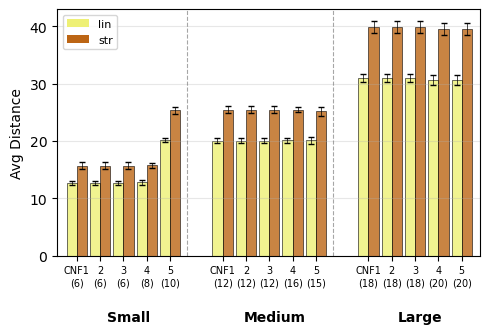

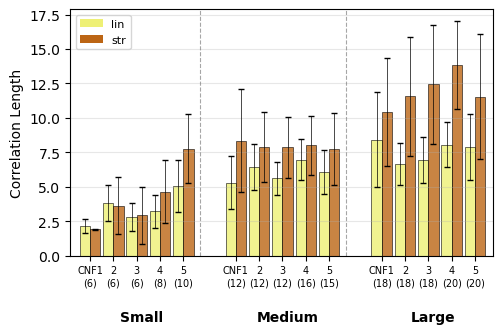

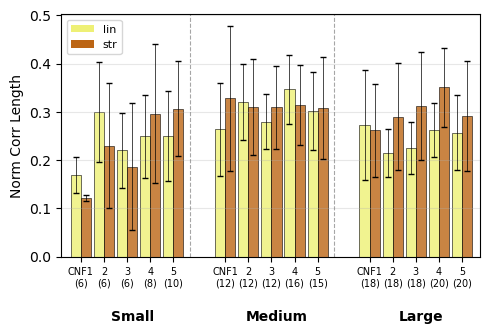

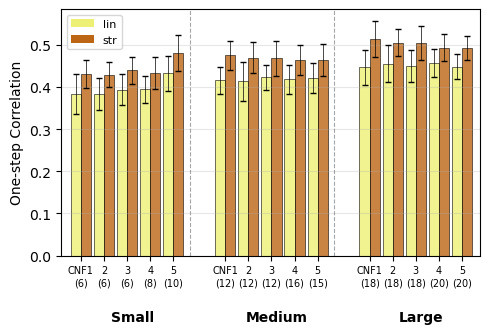

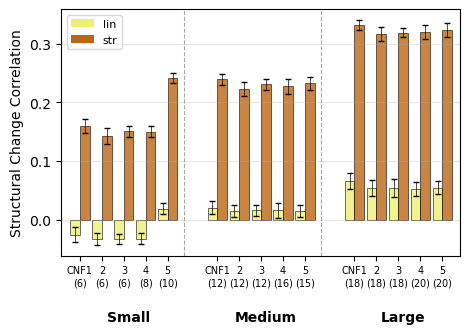

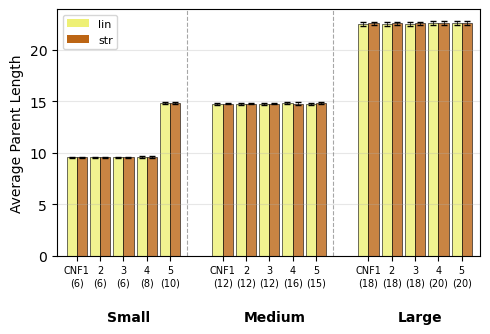

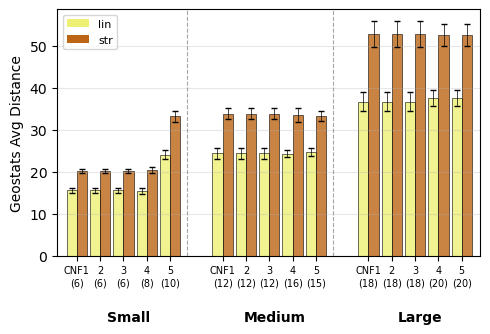

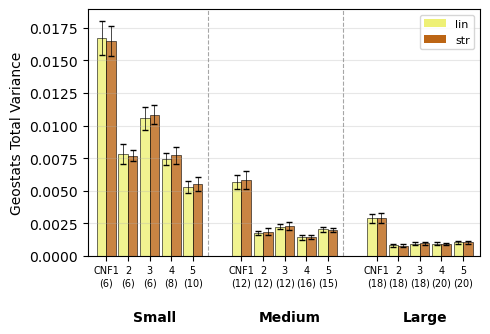

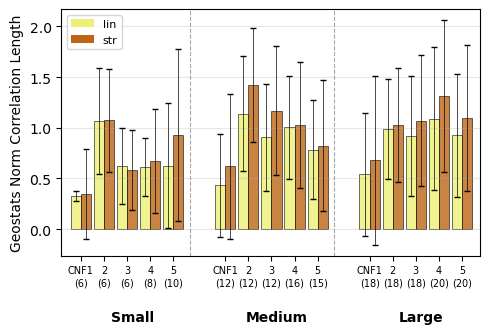

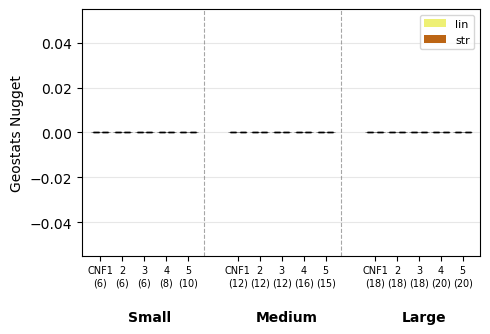

Created 10 individual metric bar plots


In [287]:
# Visualize each metric separately with individual bar plots
# X-axis: size_cat x problem (paired lin/str bars)
# Drop OneMax

# Use only the base metric names (without _mean or _std suffix)
summary_cols = ['avg_dist', 'cor_length', 'norm_corr_length', 'onestep_cor', 'sr_structural_change_cor',
                'sr_average_parent_length', 'g_avg_dist', 'g_total_var',
                'g_norm_corr_length', 'g_nugget']

# Prepare data for plotting
plot_data = correlation_summary.reset_index()

# Drop OneMax
plot_data = plot_data[plot_data['problem'] != 'OneMax']

# Add size_cat column based on size
def get_size_cat(row):
    problem = row['problem']
    size = row['size']
    if problem in ['BFS-CNF1', 'BFS-CNF2', 'BFS-CNF3']:
        if size == 6:
            return 'small'
        elif size == 12:
            return 'medium'
        elif size == 18:
            return 'large'
    elif problem == 'BFS-CNF4':
        if size == 8:
            return 'small'
        elif size == 16:
            return 'medium'
        elif size == 20:
            return 'large'
    elif problem == 'BFS-CNF5':
        if size == 10:
            return 'small'
        elif size == 15:
            return 'medium'
        elif size == 20:
            return 'large'
    return None

plot_data['size_cat'] = plot_data.apply(get_size_cat, axis=1)

# Define metric labels for titles
metric_label_map = {
    'avg_dist': 'Avg Distance',
    'cor_length': 'Correlation Length',
    'norm_corr_length': 'Norm Corr Length',
    'onestep_cor': 'One-step Correlation',
    'sr_structural_change_cor': 'Structural Change Correlation',
    'sr_average_parent_length': 'Average Parent Length',
    'g_avg_dist': 'Geostats Avg Distance',
    'g_total_var': 'Geostats Total Variance',
    'g_norm_corr_length': 'Geostats Norm Correlation Length',
    'g_nugget': 'Geostats Nugget'
}

# Sort by size_cat then problem
size_cat_order = ['small', 'medium', 'large']
plot_data['size_cat'] = pd.Categorical(plot_data['size_cat'], categories=size_cat_order, ordered=True)
plot_data = plot_data.sort_values(['size_cat', 'problem'])

# Create one plot per metric
for metric in summary_cols:
    # Even narrower figure - 5" wide
    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

    # Build x-axis positions with spacing between size categories
    current_x = 0
    width = 0.35
    size_cat_spacing = 1.0  # Extra space between size categories
    
    x_tick_positions = []
    x_tick_labels = []
    
    for size_cat_idx, size_cat in enumerate(size_cat_order):
        size_cat_data = plot_data[plot_data['size_cat'] == size_cat]
        
        if len(size_cat_data) == 0:
            continue
        
        # Mark start of size category
        size_cat_start_x = current_x
        
        # Get unique problems for this size category
        problems = size_cat_data['problem'].unique()
        
        for prob_idx, problem in enumerate(problems):
            prob_data = size_cat_data[size_cat_data['problem'] == problem]
            
            # Get lin and str values for this problem
            lin_row = prob_data[prob_data['name_type'] == 'lin']
            str_row = prob_data[prob_data['name_type'] == 'str']
            
            # Get mean and std for plotting
            lin_val = lin_row[f'{metric}_mean'].iloc[0] if len(lin_row) > 0 else 0
            lin_err = lin_row[f'{metric}_std'].iloc[0] if len(lin_row) > 0 else 0
            str_val = str_row[f'{metric}_mean'].iloc[0] if len(str_row) > 0 else 0
            str_err = str_row[f'{metric}_std'].iloc[0] if len(str_row) > 0 else 0
            
            # Get size for label
            size = prob_data['size'].iloc[0]
            
            # Plot paired bars with error bars
            ax.bar(current_x, lin_val, width, color="#EEF075", alpha=0.8, 
                   edgecolor='black', linewidth=0.5,
                   yerr=lin_err, capsize=2, error_kw={'linewidth': 0.5})
            ax.bar(current_x + width, str_val, width, color="#BC6514", alpha=0.8,
                   edgecolor='black', linewidth=0.5,
                   yerr=str_err, capsize=2, error_kw={'linewidth': 0.5})
            
            # Add problem label with size at the midpoint of the pair
            x_tick_positions.append(current_x + width/2)
            problem_short = problem.replace('BFS-', '')
            # Abbreviate: "CNF1" for first, then just number for others
            if prob_idx == 0:
                label_text = f'{problem_short}\n({size})'
            else:
                # Extract just the number from "CNF2", "CNF3", etc.
                cnf_num = problem_short.replace('CNF', '')
                label_text = f'{cnf_num}\n({size})'
            x_tick_labels.append(label_text)
            
            current_x += 2 * width + 0.1  # Small gap between pairs
        
        # Add size category label
        size_cat_end_x = current_x - 0.1
        size_cat_mid_x = (size_cat_start_x + size_cat_end_x) / 2
        
        # Add vertical line to separate size categories (except after last)
        if size_cat_idx < len(size_cat_order) - 1:
            ax.axvline(x=current_x - 0.05, color='gray', linestyle='--', 
                      linewidth=0.8, alpha=0.7)
        
        # Label size category below axis
        ax.text(size_cat_mid_x, -0.22, size_cat.capitalize(), transform=ax.get_xaxis_transform(),
               ha='center', va='top', fontsize=10, fontweight='bold')
        
        current_x += size_cat_spacing  # Extra space before next size category

    # Formatting
    ax.set_ylabel(metric_label_map[metric], fontsize=10)
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, fontsize=7)
    ax.set_xlabel('', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xlim(-0.5, current_x - size_cat_spacing)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor="#EEF075", label='lin'),
                       Patch(facecolor="#BC6514", label='str')]
    ax.legend(handles=legend_elements, loc='best', fontsize=8)

    plt.tight_layout()
    plt.savefig(f'outputs/metric_{metric}_barplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

print(f"Created {len(summary_cols)} individual metric bar plots")

## 2. Plot Correlogram Curves

Read each xy results file and create plots in PDF format.

In [135]:
# Find all xy CSV files
xy_files = glob.glob('outputs/results_2026_01_07_correlogram_xy_*.csv')
print(f"Found {len(xy_files)} xy files to plot")

Found 36 xy files to plot


In [136]:
sorted(xy_files)

['outputs/results_2026_01_07_correlogram_xy_BFS-CNF1_12_medium_100000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF1_12_medium_100000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF1_18_large_1000000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF1_18_large_1000000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF1_6_small_20000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF1_6_small_20000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF2_12_medium_100000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF2_12_medium_100000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF2_18_large_1000000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF2_18_large

In [137]:
# Create plots for each xy file and save as PDF
for xy_file in xy_files:
    # Read the xy data
    xy_df = pd.read_csv(xy_file)
    
    # Extract metadata from filename
    # Format: results_2026_01_07_correlogram_xy_{problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_rep{rep}.csv
    filename = Path(xy_file).stem
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Log-scaled marker sizes based on n_axis
    if 'n_axis' in xy_df.columns:
        marker_sizes = np.log10(xy_df['n_axis'] + 1) * 30
    else:
        marker_sizes = 50  # default if n_axis not available
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, edgecolors='black', linewidth=0.5)
    plt.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=1, alpha=0.4, color='gray')
    plt.xlabel('Distance', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.title(filename.replace('results_2026_01_07_correlogram_xy_', '').replace('_', ' '), fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Add legend for marker sizes if n_axis is available
    if 'n_axis' in xy_df.columns:
        from matplotlib.lines import Line2D
        n_min, n_max = xy_df['n_axis'].min(), xy_df['n_axis'].max()
        n_reference = [10, 100, 1000, 10000, 100000]
        n_reference = [n for n in n_reference if n_min <= n <= n_max]
        if len(n_reference) > 0:
            legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor='gray', 
                                      markersize=np.sqrt(np.log10(n+1)*30/np.pi),
                                      label=f'n={n:,}') 
                               for n in n_reference]
            plt.legend(handles=legend_elements, title='Pairs per bin', loc='best', framealpha=0.9, fontsize=9)
        
        # Add text showing range
        plt.text(0.02, 0.98, f'n range: {int(n_min):,}-{int(n_max):,}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top',
                 fontsize=8,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Save as PDF
    pdf_filename = xy_file.replace('.csv', '.pdf')
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.close()
    
print(f"Created {len(xy_files)} PDF plots")

Created 36 PDF plots


## 3. Summary Statistics by Problem Type

Additional analysis grouping by different dimensions.

## Display Correlogram Plots in Grid

Display all correlogram plots in a grid layout within the notebook.

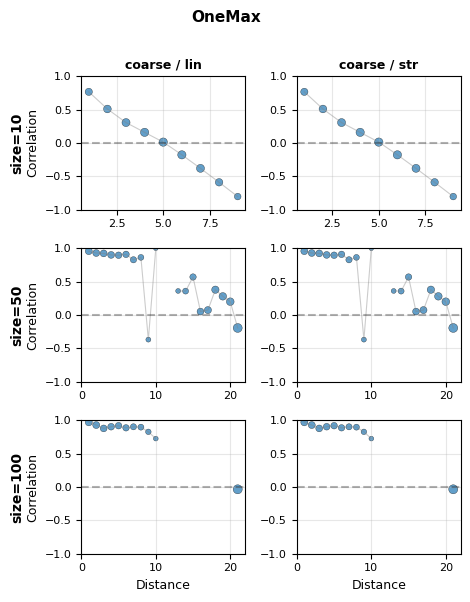

Created grid for OneMax with 3 sizes: [10, 50, 100]


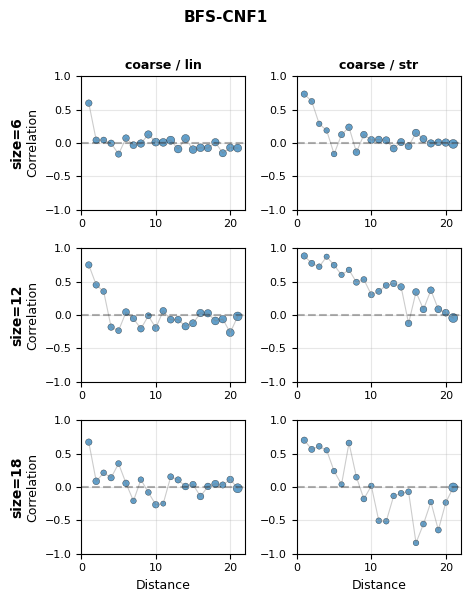

Created grid for BFS-CNF1 with 3 sizes: [6, 12, 18]


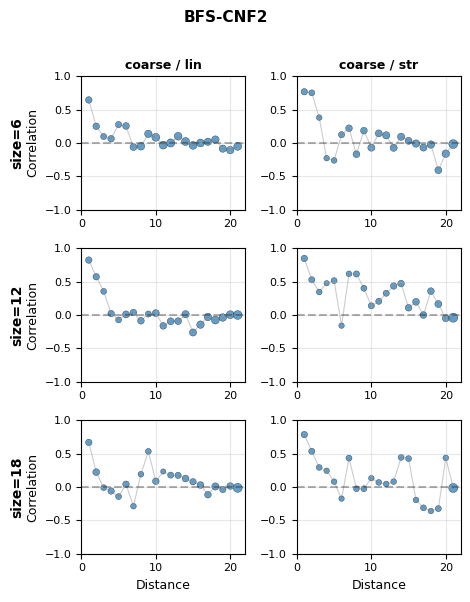

Created grid for BFS-CNF2 with 3 sizes: [6, 12, 18]


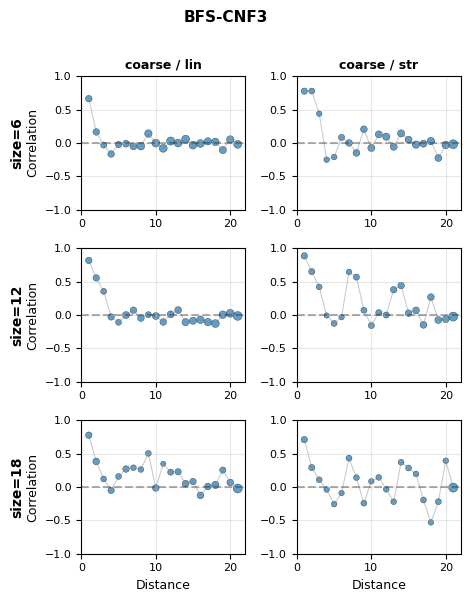

Created grid for BFS-CNF3 with 3 sizes: [6, 12, 18]


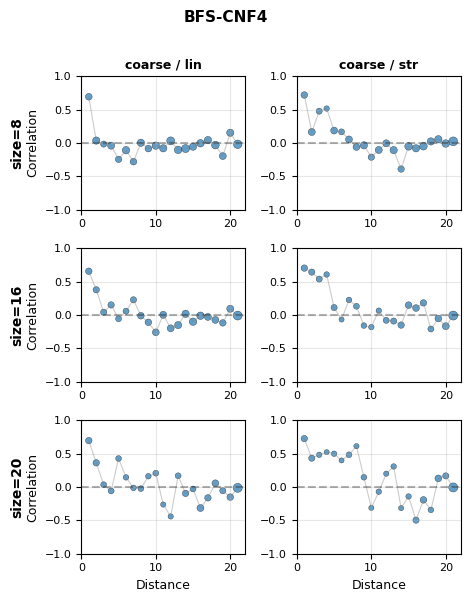

Created grid for BFS-CNF4 with 3 sizes: [8, 16, 20]


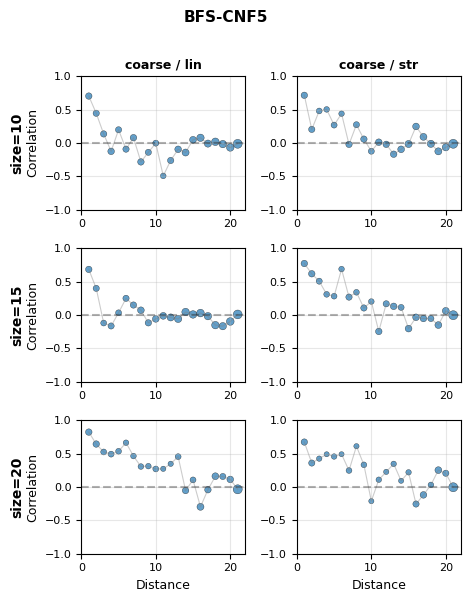

Created grid for BFS-CNF5 with 3 sizes: [10, 15, 20]
Created grids for 6 problems


In [138]:
# Create a grid of plots - one grid per problem
# Within each grid: rows = problem sizes, columns = name_type x dist_type

# Parse filenames to get metadata
plot_data = []
for xy_file in xy_files:
    filename = Path(xy_file).stem
    # Extract parts from filename
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Parse: {problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_{generator}_rep{rep}
    try:
        problem = parts[0]
        size = int(parts[1])
        size_cat = parts[2]
        budget = int(parts[3])
        dist_type = parts[4]
        name_type = parts[5]
        generator = parts[6]
        rep = parts[7].replace('rep', '')
        
        plot_data.append({
            'file': xy_file,
            'problem': problem,
            'size': size,
            'size_cat': size_cat,
            'budget': budget,
            'dist_type': dist_type,
            'name_type': name_type,
            'rep': rep
        })
    except:
        print(f"Warning: Could not parse {filename}")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)
plot_df['problem'] = pd.Categorical(plot_df['problem'], categories=problem_ordering, ordered=True)
plot_df = plot_df.sort_values(['problem', 'size', 'dist_type', 'name_type'])

# Get unique problems and combinations
problems = plot_df['problem'].unique()
dist_types = sorted(plot_df['dist_type'].unique())
name_types = sorted(plot_df['name_type'].unique())

# Create column labels for all combinations of dist_type x name_type
columns = [(dt, nt) for dt in dist_types for nt in name_types]

# Create one grid per problem
for problem in problems:
    problem_df = plot_df[plot_df['problem'] == problem]
    
    if len(problem_df) == 0:
        continue
    
    # Get sizes that actually exist for this problem
    sizes = sorted(problem_df['size'].unique())
    
    # Determine grid dimensions
    n_rows = len(sizes)
    n_cols = len(columns)
    
    # Create figure with smaller size - better for papers
    # Each subplot is 2.5" x 2" instead of 5" x 4"
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2*n_rows))
    
    # Handle case of single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{problem}', fontsize=11, fontweight='bold', y=0.995)
    
    # Plot each cell
    for row_idx, size in enumerate(sizes):
        for col_idx, (dist_type, name_type) in enumerate(columns):
            ax = axes[row_idx, col_idx]
            ax.set_ylim(-1, 1)
            
            # Find the matching file
            matching = problem_df[
                (problem_df['size'] == size) & 
                (problem_df['dist_type'] == dist_type) & 
                (problem_df['name_type'] == name_type)
            ]
            
            if len(matching) > 0:
                # Read the xy data
                xy_df = pd.read_csv(matching.iloc[0]['file'])
                
                # Log-scaled marker sizes based on n_axis (smaller for smaller figure)
                if 'n_axis' in xy_df.columns:
                    marker_sizes = np.log10(xy_df['n_axis'] + 1) * 10
                else:
                    marker_sizes = 15
                
                # Plot
                ax.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, 
                          edgecolors='black', linewidth=0.3)
                ax.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=0.8, 
                       alpha=0.4, color='gray')
            else:
                # No data for this combination (shouldn't happen now, but keep as fallback)
                ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=8, color='gray')
            
            # Formatting
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
            
            # Labels with appropriate font sizes for smaller figure
            if row_idx == n_rows - 1:
                ax.set_xlabel('Distance', fontsize=9)
            if col_idx == 0:
                ax.set_ylabel('Correlation', fontsize=9)
            
            # Tick label sizes
            ax.tick_params(axis='both', labelsize=8)
            
            # Row labels (size)
            if col_idx == 0:
                ax.text(-0.35, 0.5, f'size={size}', transform=ax.transAxes,
                       fontsize=10, va='center', ha='right', fontweight='bold',
                       rotation=90)
            
            # Column labels (dist_type, name_type)
            if row_idx == 0:
                ax.set_title(f'{dist_type} / {name_type}', fontsize=9, fontweight='bold')
    
    plt.tight_layout(rect=[0.03, 0, 1, 0.99])
    plt.savefig(f'outputs/correlogram_grid_{problem}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"Created grid for {problem} with {len(sizes)} sizes: {sizes}")

print(f"Created grids for {len(problems)} problems")

In [140]:
# Group by problem only
by_problem = df.groupby('problem')[summary_cols].mean()
print("\nMean values by problem:")
by_problem


Mean values by problem:


,diameter,cor_length,onestep_cor,sr_structural_change_cor,sr_average_parent_length
problem,,,,,
BFS-CNF1,48.678016,6.866780,0.474960,0.135525,15.636433
BFS-CNF2,48.678016,4.742910,0.457235,0.116343,15.636433
BFS-CNF3,48.678016,3.600980,0.469011,0.128925,15.636433
BFS-CNF4,48.216141,5.450638,0.475375,0.110999,15.691967
BFS-CNF5,53.685909,7.844396,0.377719,0.146706,17.356033
OneMax,53.546667,11.361148,0.698295,0.000000,0.000000


In [141]:
# Group by size only
by_size = df.groupby('size')[summary_cols].mean()
print("\nMean values by size:")
by_size


Mean values by size:


,diameter,cor_length,onestep_cor,sr_structural_change_cor,sr_average_parent_length
size,,,,,
6,28.505000,4.167547,0.434064,0.058020,9.5541
8,29.032500,4.940898,0.437202,0.046656,9.6572
10,28.107500,5.111830,0.491994,0.070182,7.4147
12,45.722381,6.021841,0.504923,0.127065,14.7815
15,44.450000,6.589456,0.373561,0.120228,14.7100
16,45.283194,5.125798,0.513489,0.118359,14.8900
18,71.806667,5.021282,0.462219,0.195707,22.5737
20,70.332727,9.010712,0.464206,0.173754,22.5287
50,50.400000,8.692786,0.694558,0.000000,0.0000


In [142]:
# Group by dist_type and name_type
by_type = df.groupby(['dist_type', 'name_type'])[summary_cols].mean()
print("\nMean values by dist_type and name_type:")
by_type


Mean values by dist_type and name_type:


diameter  cor_length  onestep_cor  \
dist_type name_type                                       
coarse    lin        45.168897    5.685010     0.457843   
          str        55.325357    7.603941     0.526356   

                     sr_structural_change_cor  sr_average_parent_length  
dist_type name_type                                                      
coarse    lin                        0.013284                 13.323656  
          str                        0.199549                 13.328778

diameter  cor_length  onestep_cor  \
problem  size name_type                                        
OneMax   10   lin          9.940000    5.016133     0.677371   
              str          9.940000    5.016133     0.677371   
         50   lin         50.400000    8.692786     0.694558   
              str         50.400000    8.692786     0.694558   
         100  lin        100.300000   20.374527     0.722956   
              str        100.300000   20.374527     0.722956   
BFS-CNF1 6    lin         25.430000    3.701754     0.444793   
              str         31.580000    4.504333     0.472569   
         12   lin         40.591429    3.641949     0.490309   
              str         50.853333   14.752668     0.482750   
         18   lin         61.984000    6.176527     0.385969   
              str         81.629333    8.423450     0.573369   
BFS-CNF2 6    lin         25.430000    6.775581     0.396340   
              str         31.580000    3.609610     0.450508   
         12   lin         40.591429    4.126336     0.485892   
              str         50.853333    5.749061     0.549365   
         18   lin         61.984000    2.917439     0.322982   
              str         81.629333    5.279432     0.538324   
BFS-CNF3 6    lin         25.430000    2.790925     0.366506   
              str         31.580000    3.623080     0.473666   
         12   lin         40.591429    3.900836     0.502727   
              str         50.853333    3.960197     0.518497   
         18   lin         61.984000    3.651644     0.367060   
              str         81.629333    3.679197     0.585611   
BFS-CNF4 8    lin         25.925000    2.499452     0.410633   
              str         32.140000    7.382345     0.463770   
         16   lin         39.997500    4.681746     0.495817   
              str         50.568889    5.569851     0.531160   
         20   lin         61.238182    3.272418     0.421494   
              str         79.427273    9.298018     0.529373   
BFS-CNF5 10   lin         40.635000    3.482138     0.369903   
              str         51.915000    6.932914     0.243330   
         15   lin         39.350000    2.749798     0.295014   
              str         49.550000   10.429114     0.452108   
         20   lin         61.238182   13.878184     0.390843   
              str         79.427273    9.594228     0.515114   

                         sr_structural_change_cor  sr_average_parent_length  
problem  size name_type                                                      
OneMax   10   lin                        0.000000                    0.0000  
              str                        0.000000                    0.0000  
         50   lin                        0.000000                    0.0000  
              str                        0.000000                    0.0000  
         100  lin                        0.000000                    0.0000  
              str                        0.000000                    0.0000  
BFS-CNF1 6    lin                       -0.035271                    9.5918  
              str                        0.169364                    9.5164  
         12   lin                        0.029026                   14.8282  
              str                        0.236225                   14.7348  
         18   lin                        0.084704                   22.5546  
              str                        0.329104                   22.5928  
BFS-CNF2 6    lin                       -0.036824                    9.5918  
              str                        0.123807                    9.5164  
         12   lin                        0.015781                   14.8282  
              str                        0.223056                   14.7348  
         18   lin                        0.050383                   22.5546  
              str                        0.321852                   22.5928  
BFS-CNF3 6    lin                 

## Variogram

In [225]:
from skgstat import Variogram, MetricSpace

# model='exponential', 'spherical'
def make_variogram(dist_matrix, y, n_lags, model='spherical'):
    # copied from https://colab.research.google.com/drive/13rUkHW3DxhkRR6ZjujGjfvmp3N0U1hix

    n = len(y)
    dummy = np.random.random((n, 2)) # we will over-write                
    ms = MetricSpace(dummy) 
    ms._dists = dist_matrix

    # To get exact integer bins, we need to use maxlag and ensure bin_func creates integer bins
    # Set maxlag to n_lags so that bins will be spaced at integer intervals
    #maxlag = n_lags
    
    # 3. ANALYSIS
    # Use n_lags and maxlag to create integer-spaced bins
    # With maxlag=n_lags, the bins should be: 0, 1, 2, ..., n_lags
    V = Variogram(
        coordinates=ms,
        values=y,
        n_lags=n_lags,
        #maxlag=maxlag,
        bin_func='even',  # Even spacing
        model=model,
    )
    
    print(f"V.bins after construction: {V.bins}")
    print(f"Number of bins: {len(V.bins)}")

    # 4. NORMALIZATION
    avg_dist = np.mean(V.distance)
    total_variance = np.var(y)

    # 6. OUTPUT STATS
    norm_corr_length = V.parameters[0] / avg_dist
    return avg_dist, total_variance, norm_corr_length, V.parameters[2], V


def plot_variogram(V, avg_dist, total_variance, ax):
    """Plot a single variogram in the given axes"""
    x_dots_norm = V.bins / avg_dist
    y_dots_corr = 1 - (V.experimental / total_variance)

    # Generate smooth curve for X[0, 2]
    x_smooth_raw = np.linspace(1e-9, avg_dist * 2, 100)
    x_smooth_norm = x_smooth_raw / avg_dist
    y_smooth_corr = 1 - (V.fitted_model(x_smooth_raw) / total_variance)

    # Plot the bunched points from all walks
    ax.scatter(x_dots_norm, y_dots_corr, color='firebrick', s=15, alpha=0.6,
                edgecolors='black', linewidth=0.3)

    # Plot the interpolating trend line
    ax.plot(x_smooth_norm, y_smooth_corr, color='royalblue', linewidth=2,
            label='Fitted')

    # Formatting
    ax.set_xlim(0, 2)
    ax.set_ylim(-1, 1)
    ax.axhline(0, color='black', lw=1, alpha=0.3)
    ax.axvline(1, color='forestgreen', linestyle='--', alpha=0.5)
    ax.grid(True, linestyle=':', alpha=0.3)

In [226]:
# Find all distance matrix files (*.npy, not *_fitness.npy)
dist_matrix_files = [f for f in glob.glob('outputs/results_2026_01_07_correlogram_xy_*.npy') 
                     if not f.endswith('_fitness.npy')]
print(f"Found {len(dist_matrix_files)} distance matrix files")

# Parse filenames to get metadata
variogram_data = []
for dist_file in dist_matrix_files:
    filename = Path(dist_file).stem
    # Extract parts from filename
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Parse: {problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_{generator}_rep{rep}
    try:
        problem = parts[0]
        size = int(parts[1])
        size_cat = parts[2]
        budget = int(parts[3])
        dist_type = parts[4]
        name_type = parts[5]
        generator = parts[6]
        rep = parts[7].replace('rep', '')
        
        # Construct fitness file path
        fitness_file = dist_file.replace('.npy', '_fitness.npy')
        
        variogram_data.append({
            'dist_file': dist_file,
            'fitness_file': fitness_file,
            'problem': problem,
            'size': size,
            'size_cat': size_cat,
            'budget': budget,
            'dist_type': dist_type,
            'name_type': name_type,
            'generator': generator,
            'rep': rep
        })
    except Exception as e:
        print(f"Warning: Could not parse {filename}: {e}")

# Convert to DataFrame
variogram_df = pd.DataFrame(variogram_data)
variogram_df['problem'] = pd.Categorical(variogram_df['problem'], categories=problem_ordering, ordered=True)
variogram_df = variogram_df.sort_values(['problem', 'size', 'dist_type', 'name_type'])

print(f"Successfully parsed {len(variogram_df)} files")
variogram_df.head()

Found 180 distance matrix files
Successfully parsed 180 files


,dist_file,fitness_file,problem,size,size_cat,budget,dist_type,name_type,generator,rep
107,outputs/results_2026_01_07_correlogram_xy_OneM...,outputs/results_2026_01_07_correlogram_xy_OneM...,OneMax,10,small,10000,coarse,lin,one-max,4
119,outputs/results_2026_01_07_correlogram_xy_OneM...,outputs/results_2026_01_07_correlogram_xy_OneM...,OneMax,10,small,10000,coarse,lin,one-max,0
122,outputs/results_2026_01_07_correlogram_xy_OneM...,outputs/results_2026_01_07_correlogram_xy_OneM...,OneMax,10,small,10000,coarse,lin,one-max,1
134,outputs/results_2026_01_07_correlogram_xy_OneM...,outputs/results_2026_01_07_correlogram_xy_OneM...,OneMax,10,small,10000,coarse,lin,one-max,3
135,outputs/results_2026_01_07_correlogram_xy_OneM...,outputs/results_2026_01_07_correlogram_xy_OneM...,OneMax,10,small,10000,coarse,lin,one-max,2


V.bins after construction: [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
Number of bins: 20
V.bins after construction: [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
Number of bins: 20
V.bins after construction: [ 1.95  3.9   5.85  7.8   9.75 11.7  13.65 15.6  17.55 19.5  21.45 23.4
 25.35 27.3  29.25 31.2  33.15 35.1  37.05 39.  ]
Number of bins: 20
V.bins after construction: [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40.]
Number of bins: 20
V.bins after construction: [ 3.45  6.9  10.35 13.8  17.25 20.7  24.15 27.6  31.05 34.5  37.95 41.4
 44.85 48.3  51.75 55.2  58.65 62.1  65.55 69.  ]
Number of bins: 20
V.bins after construction: [ 3.55  7.1  10.65 14.2  17.75 21.3  24.85 28.4  31.95 35.5  39.05 42.6
 46.15 49.7  53.25 56.8  60.35 63.9  67.45 71.  ]
Number of bins: 20


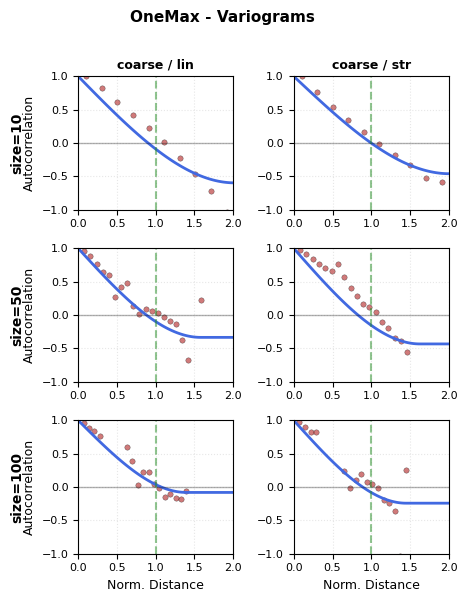

Created variogram grid for OneMax with 3 sizes: [10, 50, 100]
V.bins after construction: [ 1.4  2.8  4.2  5.6  7.   8.4  9.8 11.2 12.6 14.  15.4 16.8 18.2 19.6
 21.  22.4 23.8 25.2 26.6 28. ]
Number of bins: 20
V.bins after construction: [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40.]
Number of bins: 20
V.bins after construction: [ 2.4  4.8  7.2  9.6 12.  14.4 16.8 19.2 21.6 24.  26.4 28.8 31.2 33.6
 36.  38.4 40.8 43.2 45.6 48. ]
Number of bins: 20
V.bins after construction: [ 3.6  7.2 10.8 14.4 18.  21.6 25.2 28.8 32.4 36.  39.6 43.2 46.8 50.4
 54.  57.6 61.2 64.8 68.4 72. ]
Number of bins: 20
V.bins after construction: [ 4.3  8.6 12.9 17.2 21.5 25.8 30.1 34.4 38.7 43.  47.3 51.6 55.9 60.2
 64.5 68.8 73.1 77.4 81.7 86. ]
Number of bins: 20
V.bins after construction: [  6.05  12.1   18.15  24.2   30.25  36.3   42.35  48.4   54.45  60.5
  66.55  72.6   78.65  84.7   90.75  96.8  102.85 108.9  114.95 121.  ]
Number of bins: 20


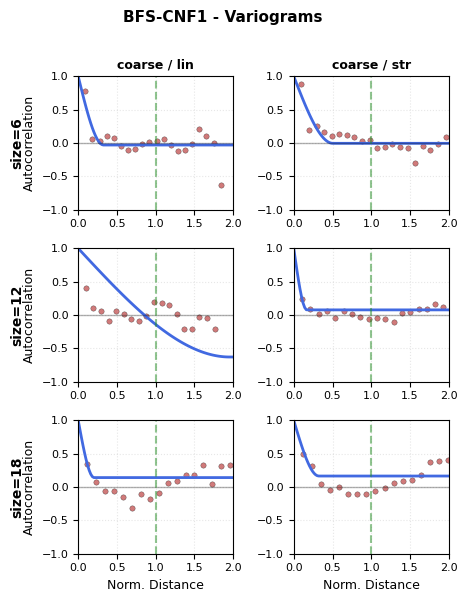

Created variogram grid for BFS-CNF1 with 3 sizes: [6, 12, 18]
V.bins after construction: [ 1.5  3.   4.5  6.   7.5  9.  10.5 12.  13.5 15.  16.5 18.  19.5 21.
 22.5 24.  25.5 27.  28.5 30. ]
Number of bins: 20
V.bins after construction: [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40.]
Number of bins: 20
V.bins after construction: [ 2.6  5.2  7.8 10.4 13.  15.6 18.2 20.8 23.4 26.  28.6 31.2 33.8 36.4
 39.  41.6 44.2 46.8 49.4 52. ]
Number of bins: 20
V.bins after construction: [ 3.6  7.2 10.8 14.4 18.  21.6 25.2 28.8 32.4 36.  39.6 43.2 46.8 50.4
 54.  57.6 61.2 64.8 68.4 72. ]
Number of bins: 20
V.bins after construction: [ 3.5  7.  10.5 14.  17.5 21.  24.5 28.  31.5 35.  38.5 42.  45.5 49.
 52.5 56.  59.5 63.  66.5 70. ]
Number of bins: 20
V.bins after construction: [  5.65  11.3   16.95  22.6   28.25  33.9   39.55  45.2   50.85  56.5
  62.15  67.8   73.45  79.1   84.75  90.4   96.05 101.7  107.35 113.  ]
Number of bins: 20


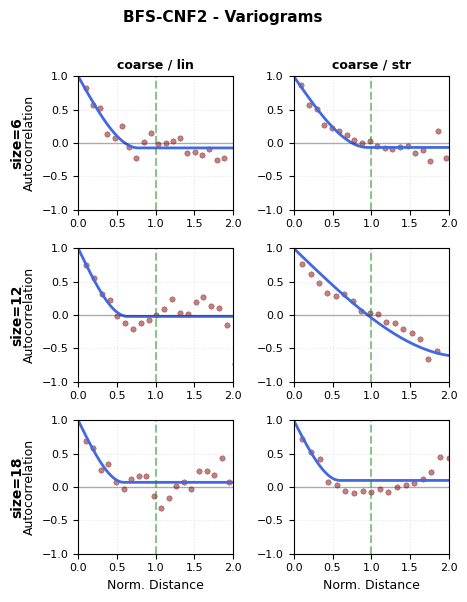

Created variogram grid for BFS-CNF2 with 3 sizes: [6, 12, 18]
V.bins after construction: [ 1.5  3.   4.5  6.   7.5  9.  10.5 12.  13.5 15.  16.5 18.  19.5 21.
 22.5 24.  25.5 27.  28.5 30. ]
Number of bins: 20
V.bins after construction: [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36.
 38. 40.]
Number of bins: 20
V.bins after construction: [ 2.6  5.2  7.8 10.4 13.  15.6 18.2 20.8 23.4 26.  28.6 31.2 33.8 36.4
 39.  41.6 44.2 46.8 49.4 52. ]
Number of bins: 20
V.bins after construction: [ 3.8  7.6 11.4 15.2 19.  22.8 26.6 30.4 34.2 38.  41.8 45.6 49.4 53.2
 57.  60.8 64.6 68.4 72.2 76. ]
Number of bins: 20
V.bins after construction: [ 3.5  7.  10.5 14.  17.5 21.  24.5 28.  31.5 35.  38.5 42.  45.5 49.
 52.5 56.  59.5 63.  66.5 70. ]
Number of bins: 20
V.bins after construction: [  6.55  13.1   19.65  26.2   32.75  39.3   45.85  52.4   58.95  65.5
  72.05  78.6   85.15  91.7   98.25 104.8  111.35 117.9  124.45 131.  ]
Number of bins: 20


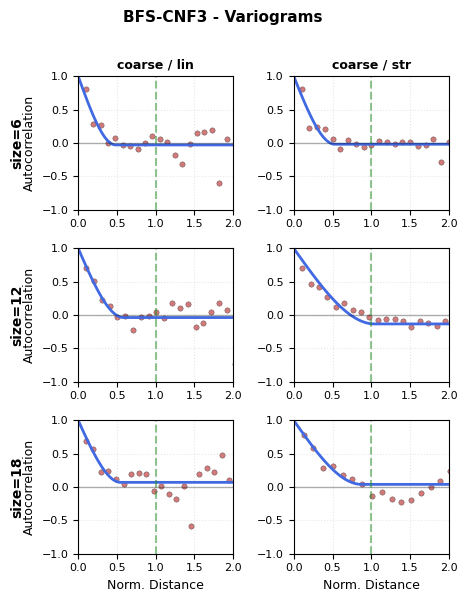

Created variogram grid for BFS-CNF3 with 3 sizes: [6, 12, 18]
V.bins after construction: [ 1.4  2.8  4.2  5.6  7.   8.4  9.8 11.2 12.6 14.  15.4 16.8 18.2 19.6
 21.  22.4 23.8 25.2 26.6 28. ]
Number of bins: 20
V.bins after construction: [ 2.1  4.2  6.3  8.4 10.5 12.6 14.7 16.8 18.9 21.  23.1 25.2 27.3 29.4
 31.5 33.6 35.7 37.8 39.9 42. ]
Number of bins: 20
V.bins after construction: [ 2.3  4.6  6.9  9.2 11.5 13.8 16.1 18.4 20.7 23.  25.3 27.6 29.9 32.2
 34.5 36.8 39.1 41.4 43.7 46. ]
Number of bins: 20
V.bins after construction: [ 4.  8. 12. 16. 20. 24. 28. 32. 36. 40. 44. 48. 52. 56. 60. 64. 68. 72.
 76. 80.]
Number of bins: 20
V.bins after construction: [ 4.2  8.4 12.6 16.8 21.  25.2 29.4 33.6 37.8 42.  46.2 50.4 54.6 58.8
 63.  67.2 71.4 75.6 79.8 84. ]
Number of bins: 20
V.bins after construction: [  5.7  11.4  17.1  22.8  28.5  34.2  39.9  45.6  51.3  57.   62.7  68.4
  74.1  79.8  85.5  91.2  96.9 102.6 108.3 114. ]
Number of bins: 20


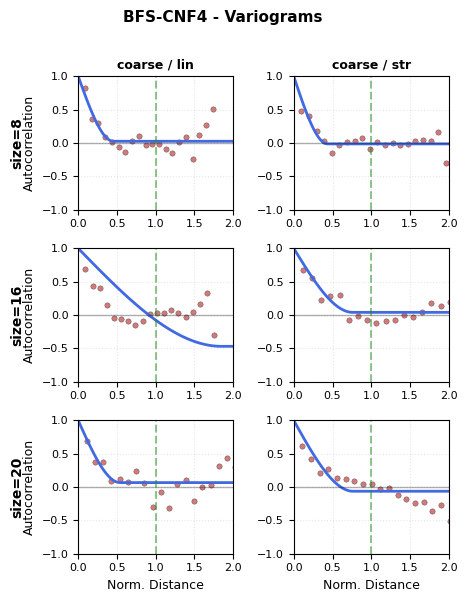

Created variogram grid for BFS-CNF4 with 3 sizes: [8, 16, 20]
V.bins after construction: [ 2.3  4.6  6.9  9.2 11.5 13.8 16.1 18.4 20.7 23.  25.3 27.6 29.9 32.2
 34.5 36.8 39.1 41.4 43.7 46. ]
Number of bins: 20
V.bins after construction: [ 3.7  7.4 11.1 14.8 18.5 22.2 25.9 29.6 33.3 37.  40.7 44.4 48.1 51.8
 55.5 59.2 62.9 66.6 70.3 74. ]
Number of bins: 20
V.bins after construction: [ 2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30.  32.5 35.
 37.5 40.  42.5 45.  47.5 50. ]
Number of bins: 20
V.bins after construction: [ 3.5  7.  10.5 14.  17.5 21.  24.5 28.  31.5 35.  38.5 42.  45.5 49.
 52.5 56.  59.5 63.  66.5 70. ]
Number of bins: 20
V.bins after construction: [ 4.  8. 12. 16. 20. 24. 28. 32. 36. 40. 44. 48. 52. 56. 60. 64. 68. 72.
 76. 80.]
Number of bins: 20
V.bins after construction: [  5.7  11.4  17.1  22.8  28.5  34.2  39.9  45.6  51.3  57.   62.7  68.4
  74.1  79.8  85.5  91.2  96.9 102.6 108.3 114. ]
Number of bins: 20


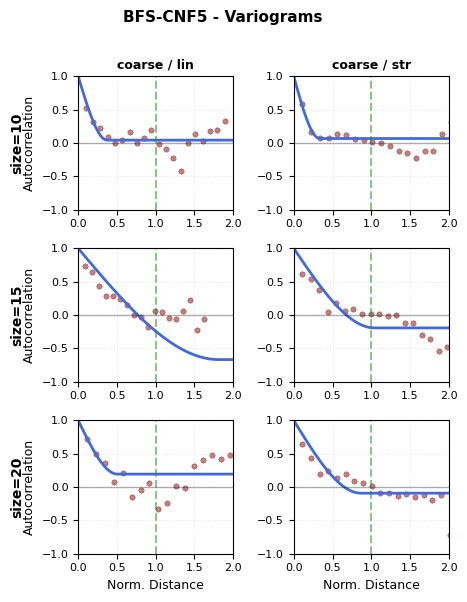

Created variogram grid for BFS-CNF5 with 3 sizes: [10, 15, 20]
Created variogram grids for 6 problems


In [227]:
# Generate variograms and create grid plots
# Parameters for variogram
N_LAGS = 20
MODEL = 'spherical'

# Get unique problems and combinations
problems = variogram_df['problem'].unique()
dist_types = sorted(variogram_df['dist_type'].unique())
name_types = sorted(variogram_df['name_type'].unique())

# Create column labels for all combinations of dist_type x name_type
columns = [(dt, nt) for dt in dist_types for nt in name_types]

# Create one grid per problem
for problem in problems:
    problem_df = variogram_df[variogram_df['problem'] == problem]
    
    if len(problem_df) == 0:
        continue
    
    # Get sizes that actually exist for this problem
    sizes = sorted(problem_df['size'].unique())
    
    # Determine grid dimensions
    n_rows = len(sizes)
    n_cols = len(columns)
    
    # Create figure with same size as correlogram grids
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2*n_rows))
    
    # Handle case of single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{problem} - Variograms', fontsize=11, fontweight='bold', y=0.995)
    
    # Plot each cell
    for row_idx, size in enumerate(sizes):
        for col_idx, (dist_type, name_type) in enumerate(columns):
            ax = axes[row_idx, col_idx]
            
            # Find the matching file
            matching = problem_df[
                (problem_df['size'] == size) & 
                (problem_df['dist_type'] == dist_type) & 
                (problem_df['name_type'] == name_type)
            ]
            
            if len(matching) > 0:
                try:
                    # Load distance matrix and fitness values
                    dist_matrix = np.load(matching.iloc[0]['dist_file'])
                    fitness_vals = np.load(matching.iloc[0]['fitness_file'])

                    max_dist = int(np.max(dist_matrix))
                    
                    # Generate variogram with explicit integer bins
                    avg_dist, total_variance, norm_corr_length, nugget, V = make_variogram(
                        dist_matrix, fitness_vals, N_LAGS, model=MODEL
                    )
                    
                    # Plot variogram
                    plot_variogram(V, avg_dist, total_variance, ax)
                    
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}', transform=ax.transAxes, 
                           ha='center', va='center', fontsize=7, color='red')
            else:
                ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=8, color='gray')
            
            # Labels with appropriate font sizes
            if row_idx == n_rows - 1:
                ax.set_xlabel('Norm. Distance', fontsize=9)
            if col_idx == 0:
                ax.set_ylabel('Autocorrelation', fontsize=9)
            
            # Tick label sizes
            ax.tick_params(axis='both', labelsize=8)
            
            # Row labels (size)
            if col_idx == 0:
                ax.text(-0.35, 0.5, f'size={size}', transform=ax.transAxes,
                       fontsize=10, va='center', ha='right', fontweight='bold',
                       rotation=90)
            
            # Column labels (dist_type, name_type)
            if row_idx == 0:
                ax.set_title(f'{dist_type} / {name_type}', fontsize=9, fontweight='bold')
    
    plt.tight_layout(rect=[0.03, 0, 1, 0.99])
    plt.savefig(f'outputs/variogram_grid_{problem}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"Created variogram grid for {problem} with {len(sizes)} sizes: {sizes}")

print(f"Created variogram grids for {len(problems)} problems")

# Solver

In [265]:
# (CNF x 5 x 3) * (solver x 2 x name_scheme x 2 + RS) * 20 reps
5 * 3 * 5 * 20



1500

In [266]:
# Read solver results
df1 = pd.read_csv('outputs/results_2026_01_22_correlogram_solver_positionwise_2overlen_CNF_clauselen_reps0_6.csv')
df2 = pd.read_csv('outputs/results_2026_01_22_correlogram_solver_positionwise_2overlen_CNF_clauselen_reps7_13.csv')
df3 = pd.read_csv('outputs/results_2026_01_22_correlogram_solver_positionwise_2overlen_CNF_clauselen_reps14_19.csv')

#df4 = pd.read_csv('outputs/results_2026_01_22_correlogram_solver_positionwise_2overlen_reps0_14.csv')
#df4 = df4[df4['problem'] == 'OneMax']
#df4['target'] = 'OneMax'



to_cat = (df1, df2, df3)
solver_df = pd.concat(to_cat)
solver_df.shape

(1500, 19)

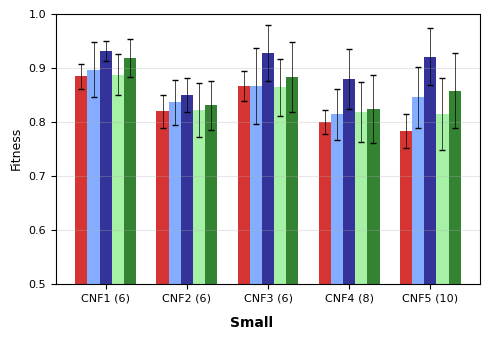

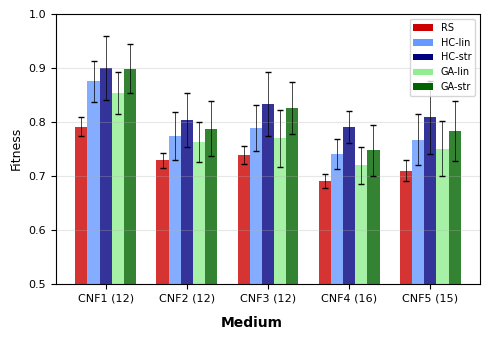

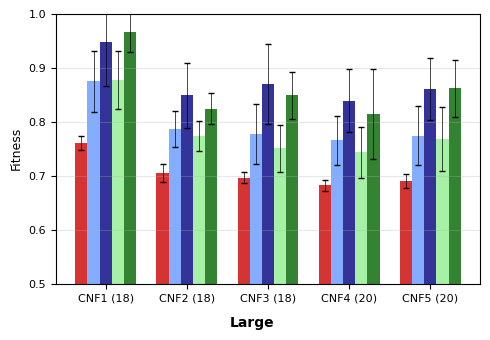

Created 3 solver performance plots (by size category)


In [273]:
# Group by problem, size, solver, name_type and aggregate statistics
groupby_cols = ['problem', 'size', 'size_cat', 'solver', 'name_type', 'generator']

# Define aggregations for each column
agg_dict = {
    'fx': ['mean', 'std', 'min', 'max'],
    'norm_fx': ['mean', 'std'],
    'elapsed': ['mean', 'std'],
    'geno_size': ['mean', 'std'],
    'hist_len': ['mean', 'std']
}

# Compute aggregations
solver_summary = solver_df.groupby(groupby_cols).agg(agg_dict)

# Flatten column names
solver_summary.columns = ['_'.join(col).strip() for col in solver_summary.columns.values]

# Apply problem ordering
solver_summary = solver_summary.reset_index()
solver_summary['problem'] = pd.Categorical(solver_summary['problem'], categories=problem_ordering, ordered=True)
solver_summary = solver_summary.sort_values(['problem', 'size', 'solver', 'name_type'])

# Visualize solver performance with separate plot per size category (omit OneMax)
# Define colors for solvers and name_types
def get_color(solver, name_type):
    if solver == 'random_search':
        return '#CC0000'  # Dark red (only lin exists)
    elif solver == 'hill_climber':
        if name_type == 'lin':
            return '#6699FF'  # Light blue
        else:  # str
            return '#000080'  # Dark blue
    else:  # genetic_algorithm
        if name_type == 'lin':
            return '#90EE90'  # Light green
        else:  # str
            return '#006400'  # Dark green

# Filter out OneMax
bfs_data = solver_summary[solver_summary['problem'] != 'OneMax']

# Get unique size categories
size_cats = ['small', 'medium', 'large']

# Create one plot per size category
for size_cat in size_cats:
    size_cat_data = bfs_data[bfs_data['size_cat'] == size_cat]
    
    if len(size_cat_data) == 0:
        continue
    
    # Get unique problems for this size category
    problems = sorted(size_cat_data['problem'].unique())
    
    # Create a mapping from problem to size for this size category
    problem_size_map = {}
    for problem in problems:
        prob_data = size_cat_data[size_cat_data['problem'] == problem]
        if len(prob_data) > 0:
            problem_size_map[problem] = prob_data['size'].iloc[0]
    
    # Create figure for conference paper (5" wide x 3.5" tall)
    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
    
    # Set up bar positions
    n_problems = len(problems)
    x = np.arange(n_problems)
    
    # Width for each bar - we have 5 bars per problem (RS-lin, HC-lin, HC-str, GA-lin, GA-str)
    width = 0.15
    
    # Define combinations (RS only has lin)
    combinations = [
        ('random_search', 'lin'),
        ('hill_climber', 'lin'),
        ('hill_climber', 'str'),
        ('genetic_algorithm', 'lin'),
        ('genetic_algorithm', 'str')
    ]
    
    # Plot bars
    bar_offset = -2 * width  # Start position for first bar
    legend_handles = []
    legend_labels = []
    
    for solver, name_type in combinations:
        # Get data for this solver/name_type combination
        filtered = size_cat_data[
            (size_cat_data['solver'] == solver) & 
            (size_cat_data['name_type'] == name_type)
        ]
        
        # Align with problems
        values = []
        errors = []
        for problem in problems:
            prob_data = filtered[filtered['problem'] == problem]
            if len(prob_data) > 0:
                # For BFS: use 1 - fx
                values.append(1.0 - prob_data['fx_mean'].iloc[0])
                errors.append(prob_data['fx_std'].iloc[0])
            else:
                values.append(0)
                errors.append(0)
        
        # Get color
        color = get_color(solver, name_type)
        
        # Plot bars with error bars
        ax.bar(x + bar_offset, values, width, color=color, alpha=0.8, 
               yerr=errors, capsize=2, error_kw={'linewidth': 0.5})
        
        # Create legend label
        solver_short = {'random_search': 'RS', 'hill_climber': 'HC', 'genetic_algorithm': 'GA'}[solver]
        if solver == 'random_search':
            label = f'{solver_short}'
        else:
            label = f'{solver_short}-{name_type}'
        
        # Only add to legend once
        if size_cat == 'medium':
            legend_handles.append(plt.Rectangle((0,0),1,1, fc=color))
            legend_labels.append(label)
        
        bar_offset += width
    
    # Formatting
    ax.set_xlabel('', fontsize=9)
    ax.set_ylabel('Fitness', fontsize=9)
    ax.set_xticks(x)
    # Create labels with problem name and size: "CNF3 (12)"
    x_labels = [f"{p.replace('BFS-', '')} ({problem_size_map[p]})" for p in problems]
    ax.set_xticklabels(x_labels, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylim(0.5, 1.0)
    ax.grid(axis='y', alpha=0.3)

    # Label size category below axis
    ax.text(1.8, -0.12, size_cat.capitalize(), transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=10, fontweight='bold')    
    
    # Add legend only on middle plot
    if size_cat == 'medium':
        ax.legend(legend_handles, legend_labels, loc='upper right', fontsize=7, ncol=1)
    
    plt.tight_layout()
    plt.savefig(f'outputs/solver_fx_{size_cat}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

print(f"Created {len(size_cats)} solver performance plots (by size category)")

In [221]:
# Find all history CSV files
history_files = glob.glob('outputs/histories_2026_01_22/history*.csv')
print(f"Found {len(history_files)} history files")

# Parse filenames to get metadata
# New format: history_{problem}_{size}_{size_cat}_{solver}_{budget}_{dist_type}_{name_type}_{generator}_{mutrate_keyword}_{rep}.csv
# Problem: solver can be multi-word with underscores (hill_climber, random_search, genetic_algorithm)
history_data = []
for hist_file in history_files:
    filename = Path(hist_file).stem
    parts = filename.replace('history_', '').split('_')
    
    try:
        # Strategy: known solvers are multi-word, so check for them
        known_solvers = ['hill_climber', 'random_search', 'genetic_algorithm']
        
        # Find which solver it is by checking if parts contain known solver names
        solver = None
        solver_start_idx = None
        for i in range(len(parts)):
            # Try to match multi-word solvers
            for known_solver in known_solvers:
                solver_parts = known_solver.split('_')
                if parts[i:i+len(solver_parts)] == solver_parts:
                    solver = known_solver
                    solver_start_idx = i
                    break
            if solver:
                break
        
        if solver is None:
            print(f"Warning: Could not identify solver in {filename}")
            continue
        
        # Now we know where the solver is, we can parse the rest
        problem = parts[0]
        size = int(parts[1])
        size_cat = parts[2]
        # solver already identified
        solver_end_idx = solver_start_idx + len(solver.split('_'))
        budget = int(parts[solver_end_idx])
        dist_type = parts[solver_end_idx + 1]
        name_type = parts[solver_end_idx + 2]
        generator = parts[solver_end_idx + 3]
        mutrate_keyword = parts[solver_end_idx + 4]  # e.g., "2overlen"
        rep = int(parts[solver_end_idx + 5])
        
        history_data.append({
            'file': hist_file,
            'problem': problem,
            'size': size,
            'size_cat': size_cat,
            'solver': solver,
            'budget': budget,
            'dist_type': dist_type,
            'name_type': name_type,
            'generator': generator,
            'mutrate_keyword': mutrate_keyword,
            'rep': rep
        })
    except Exception as e:
        print(f"Warning: Could not parse {filename}: {e}")

# Convert to DataFrame
history_df = pd.DataFrame(history_data)
history_df['problem'] = pd.Categorical(history_df['problem'], categories=problem_ordering, ordered=True)
history_df = history_df.sort_values(['problem', 'size', 'solver', 'name_type', 'rep'])

print(f"Successfully parsed {len(history_df)} files")
print(f"Unique combinations: {len(history_df.groupby(['problem', 'size', 'solver', 'name_type']))}")
history_df.head()

Found 2372 history files
Successfully parsed 2372 files
Unique combinations: 105


,file,problem,size,size_cat,solver,budget,dist_type,name_type,generator,mutrate_keyword,rep
1513,outputs/histories_2026_01_22/history_OneMax_10...,OneMax,10,small,genetic_algorithm,10000,coarse,lin,one-max,2overlen,0
1661,outputs/histories_2026_01_22/history_OneMax_10...,OneMax,10,small,genetic_algorithm,10000,coarse,lin,one-max,2overlen,1
1820,outputs/histories_2026_01_22/history_OneMax_10...,OneMax,10,small,genetic_algorithm,10000,coarse,lin,one-max,2overlen,2
1683,outputs/histories_2026_01_22/history_OneMax_10...,OneMax,10,small,genetic_algorithm,10000,coarse,lin,one-max,2overlen,3
1482,outputs/histories_2026_01_22/history_OneMax_10...,OneMax,10,small,genetic_algorithm,10000,coarse,lin,one-max,2overlen,4


Generating 60 fitness-vs-iteration plots...


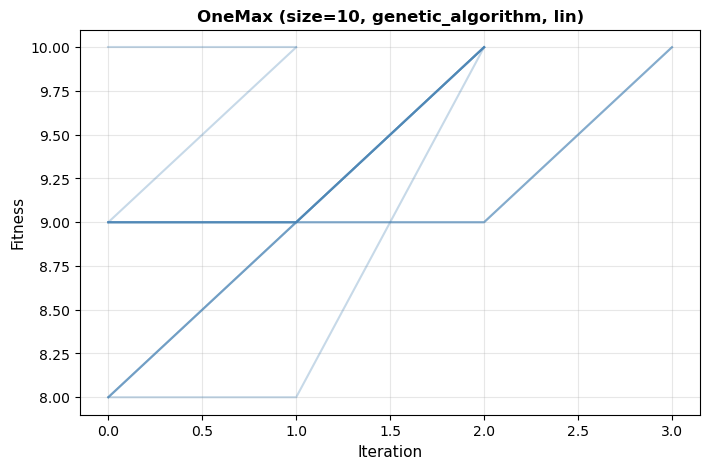

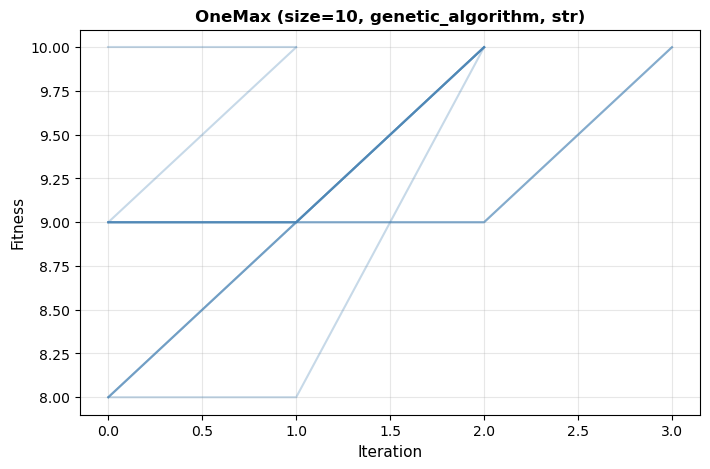

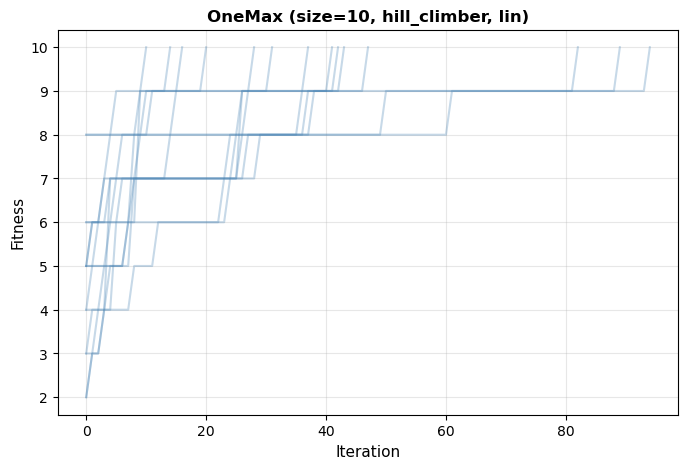

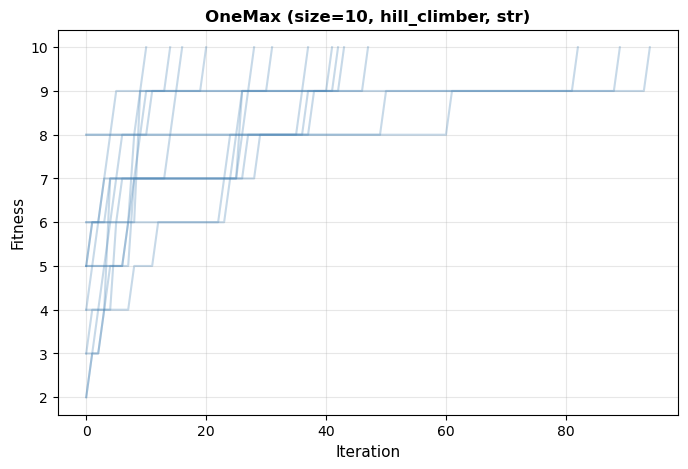

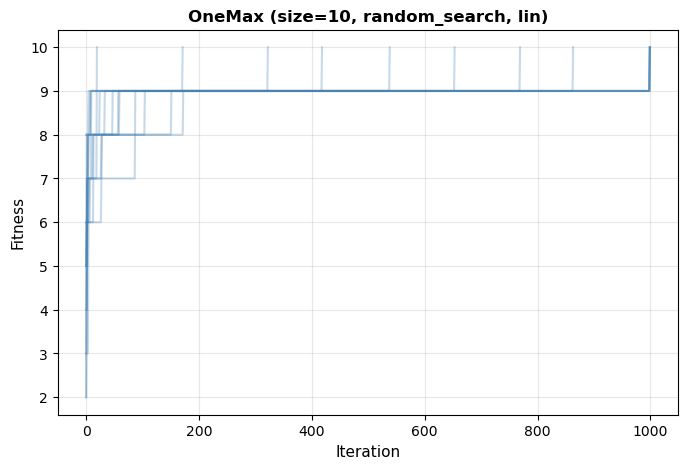

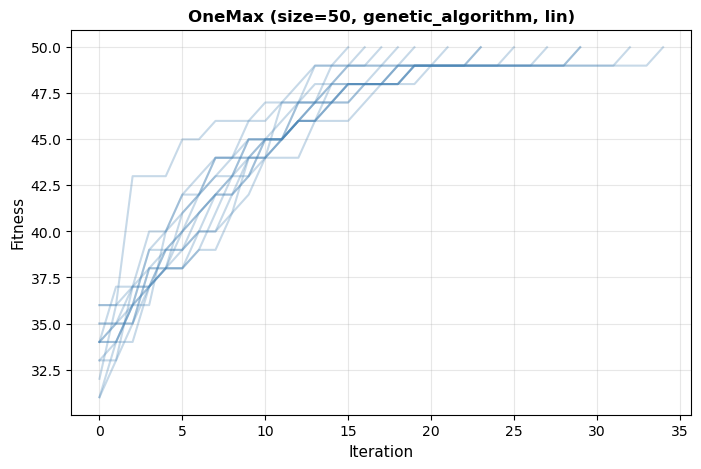

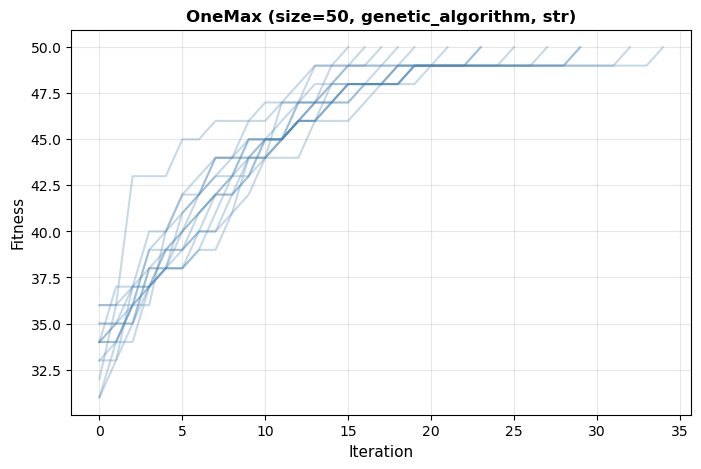

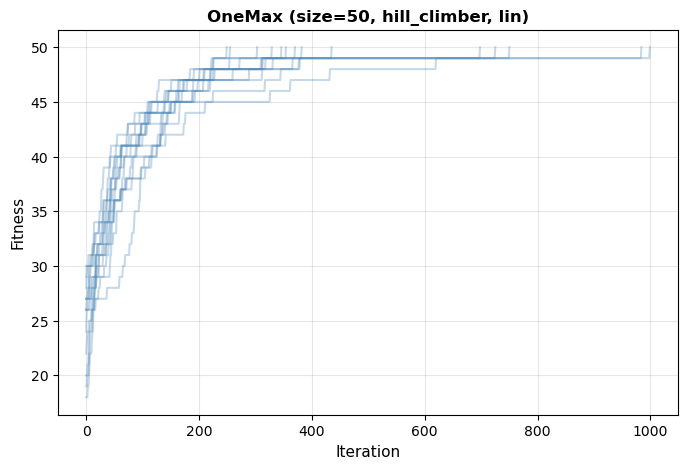

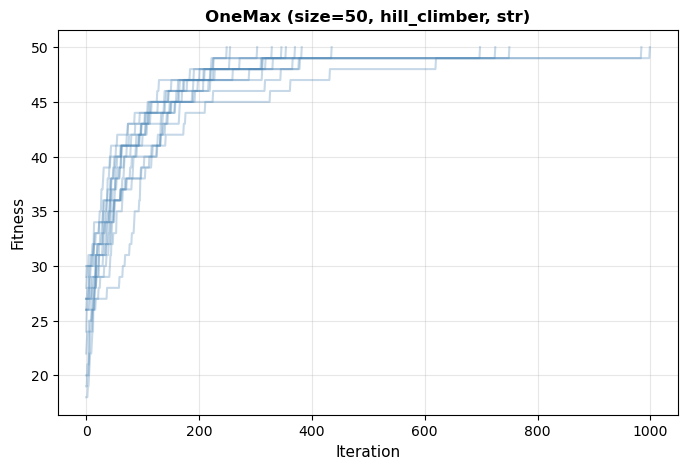

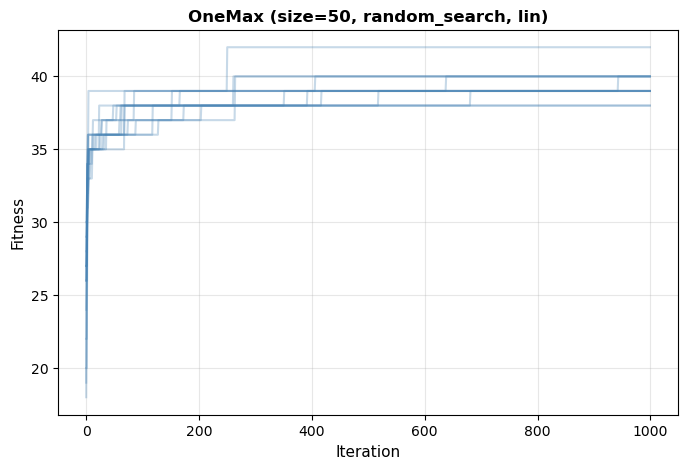

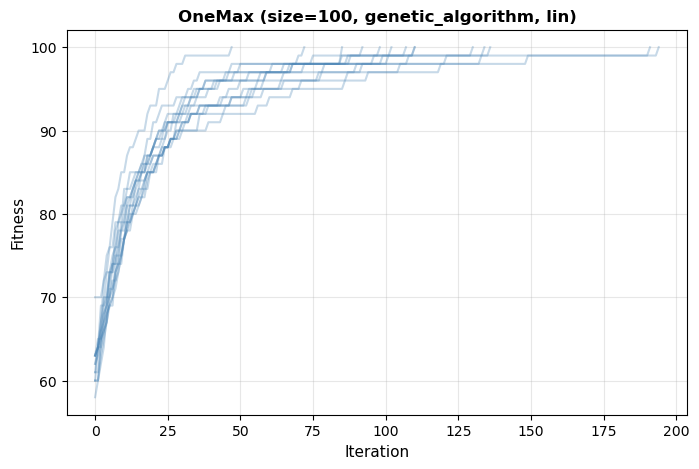

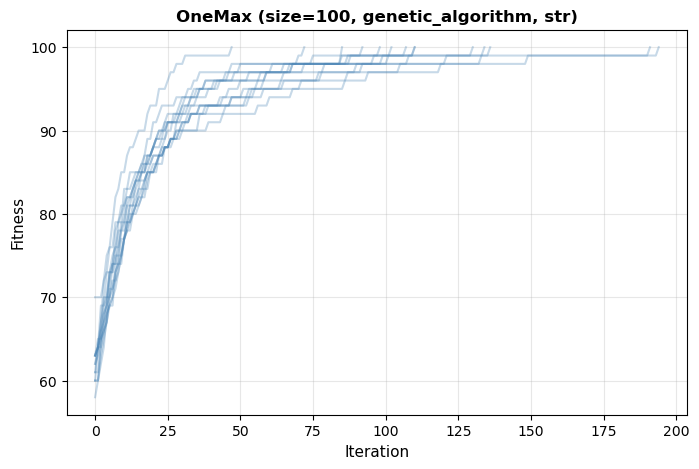

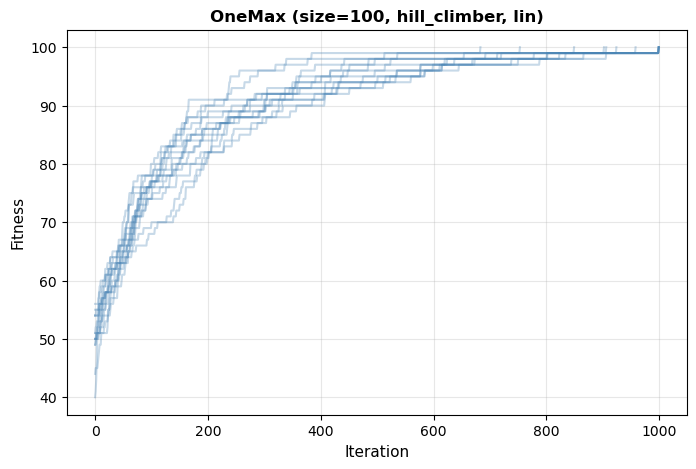

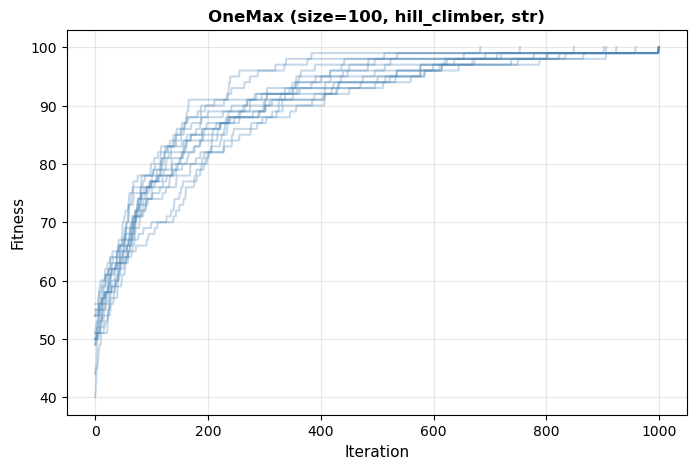

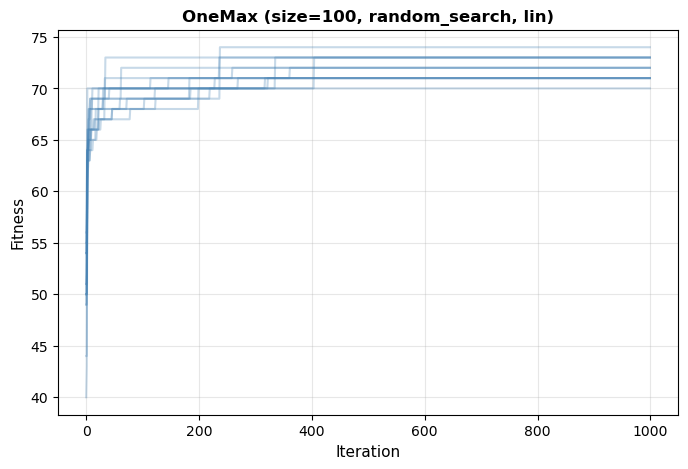

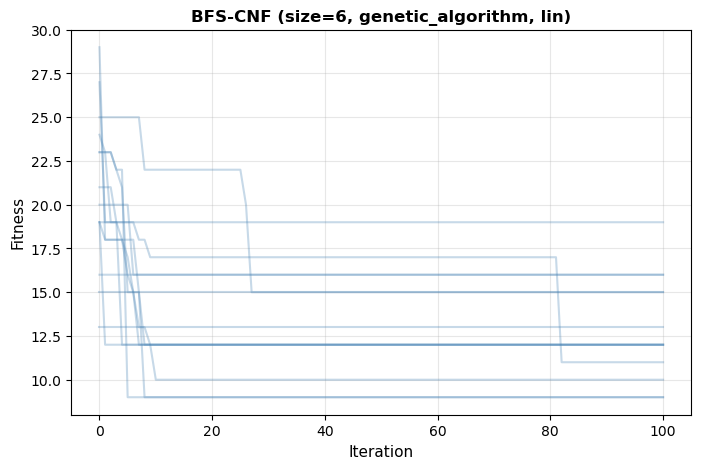

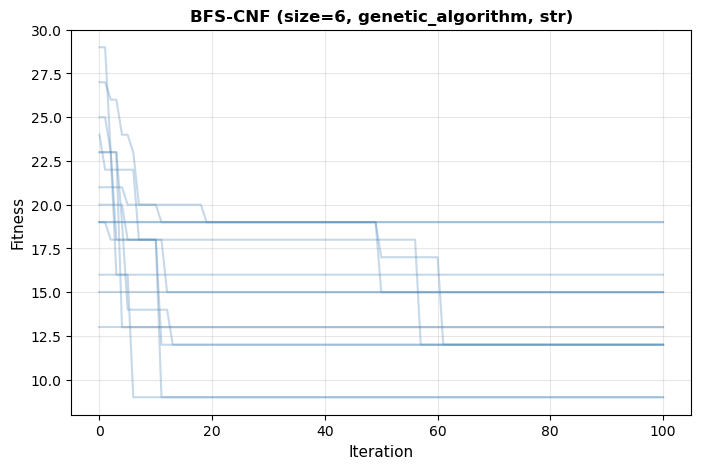

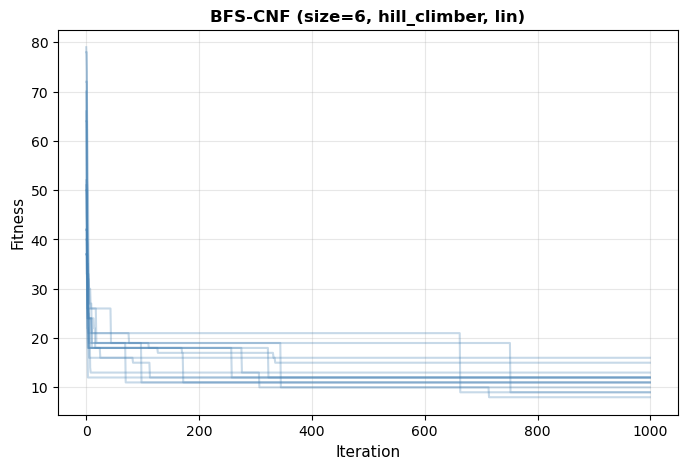

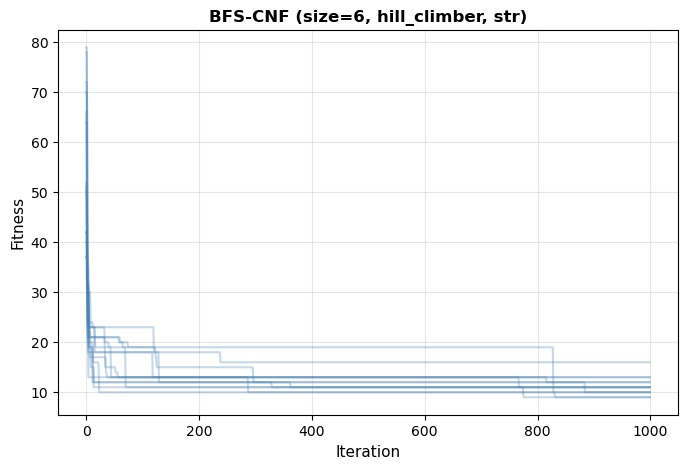

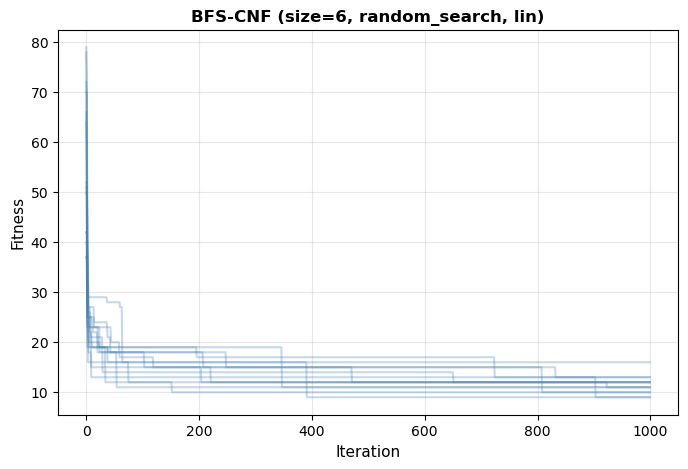

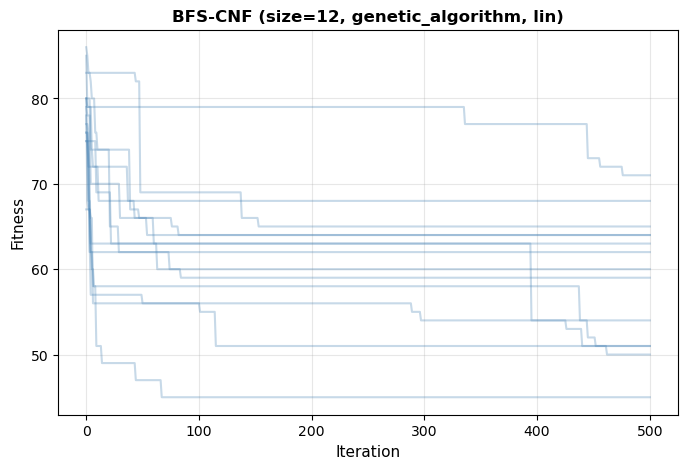

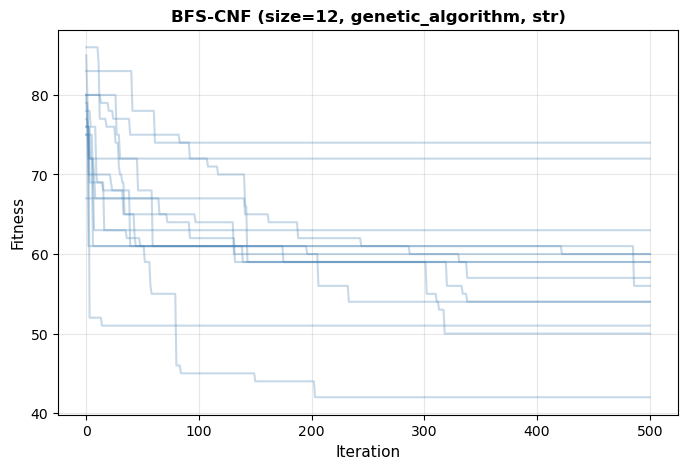

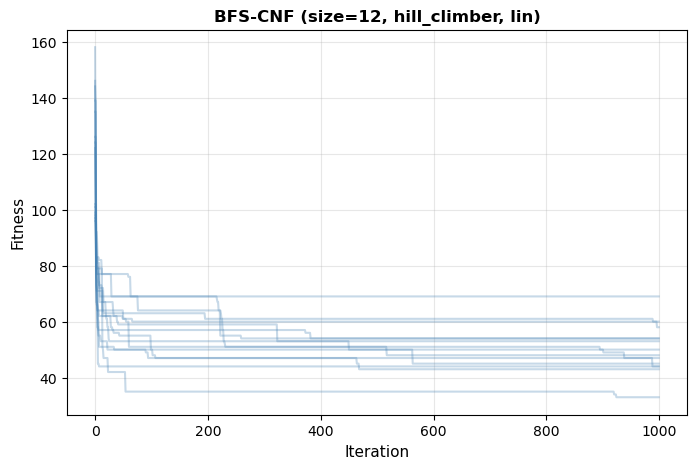

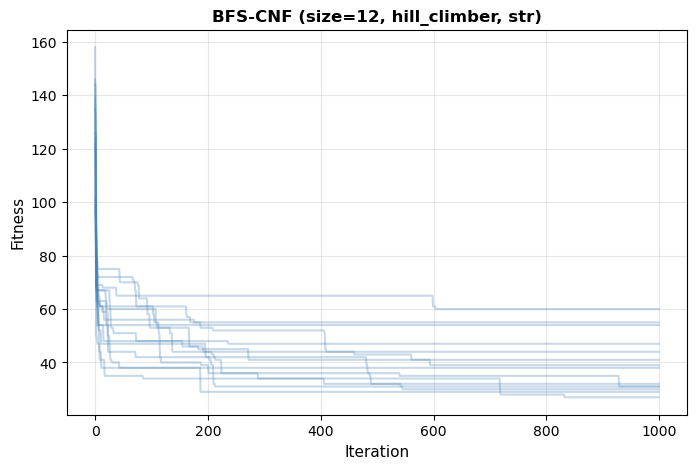

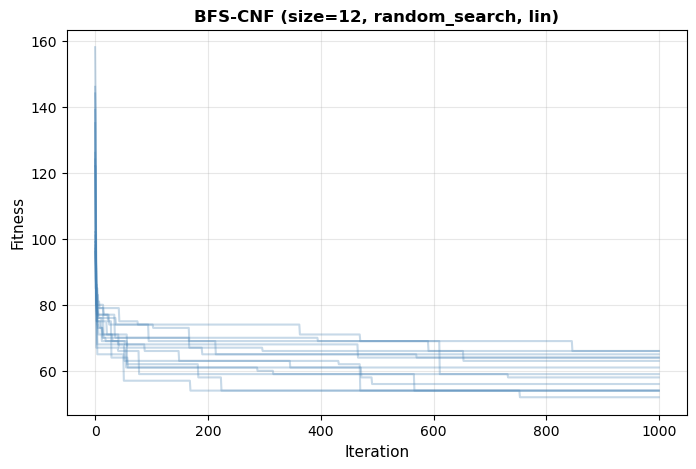

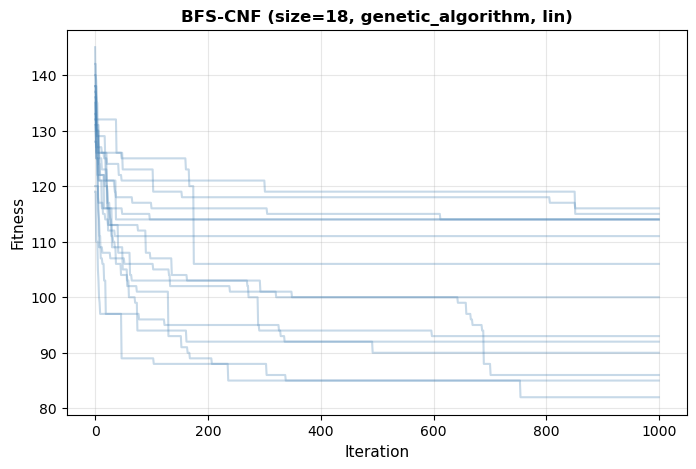

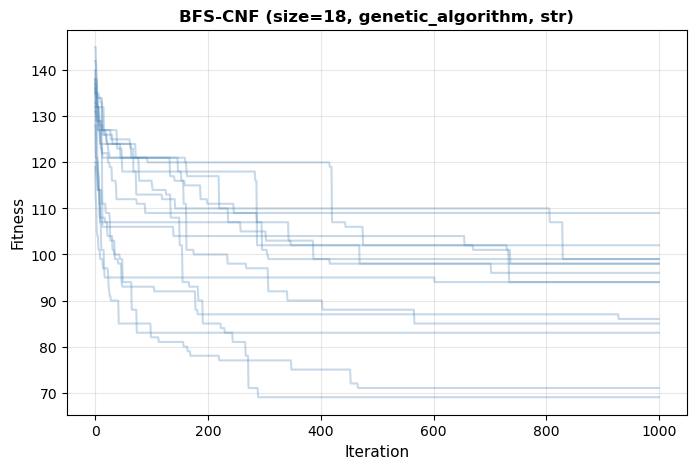

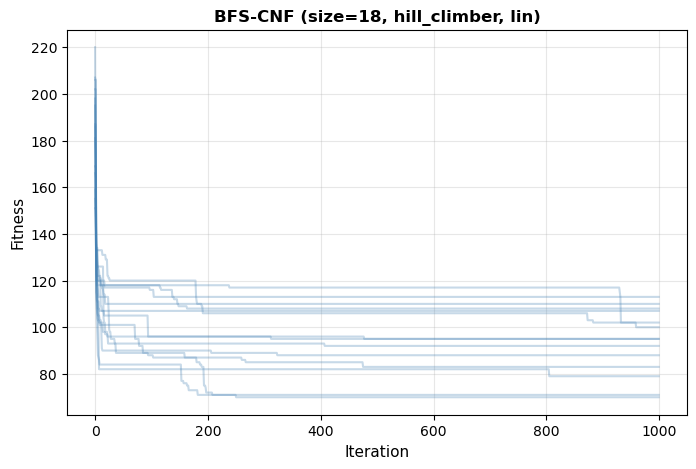

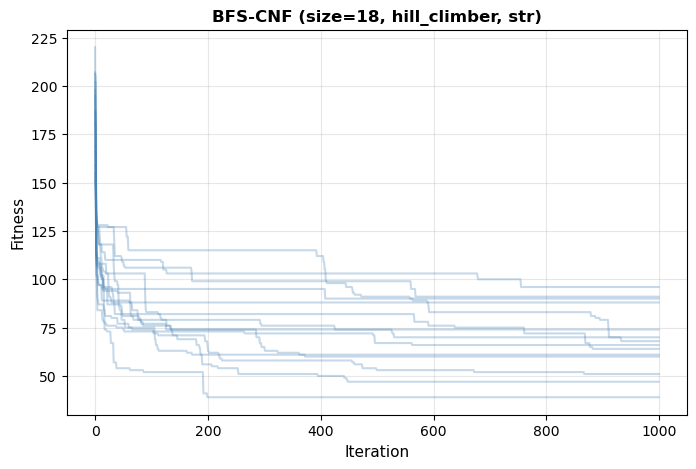

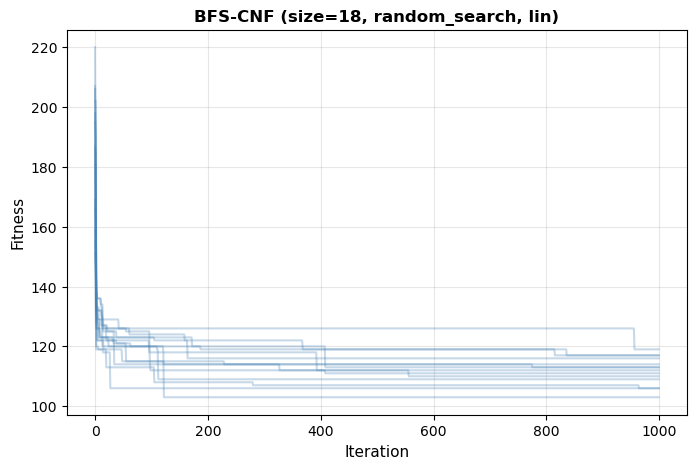

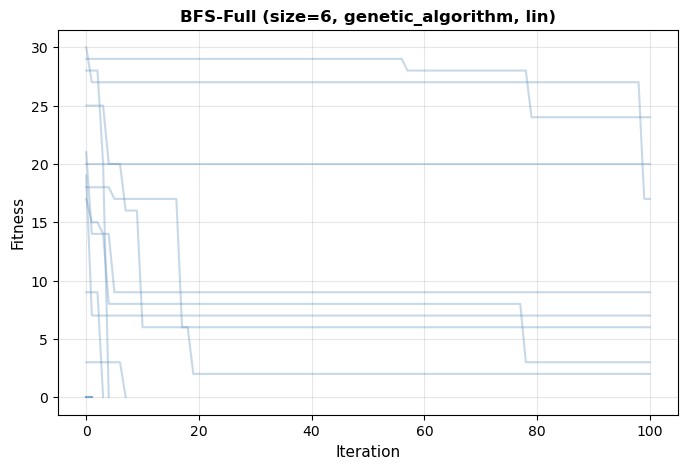

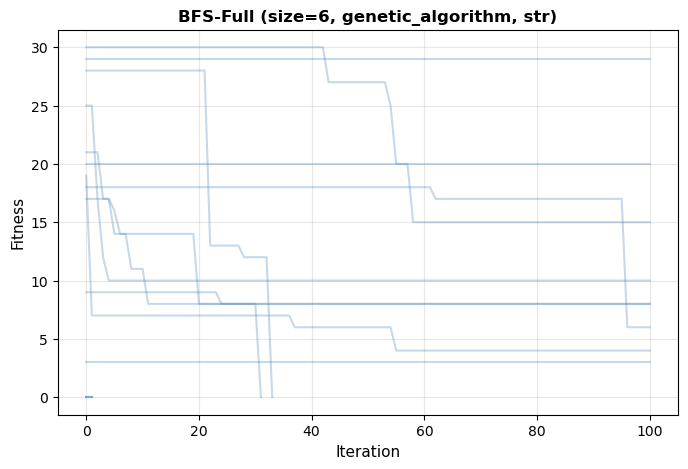

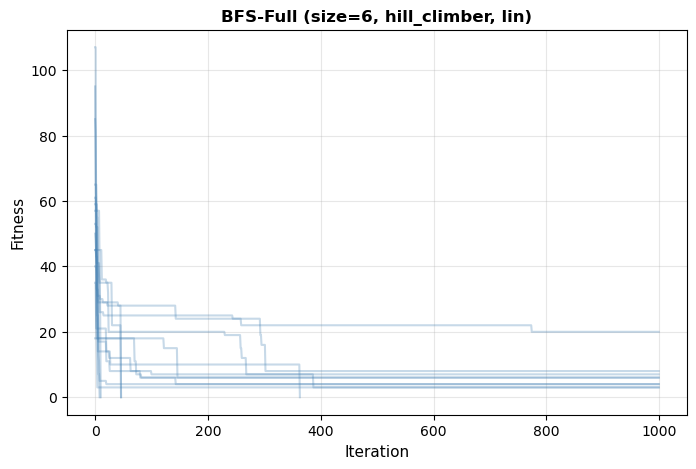

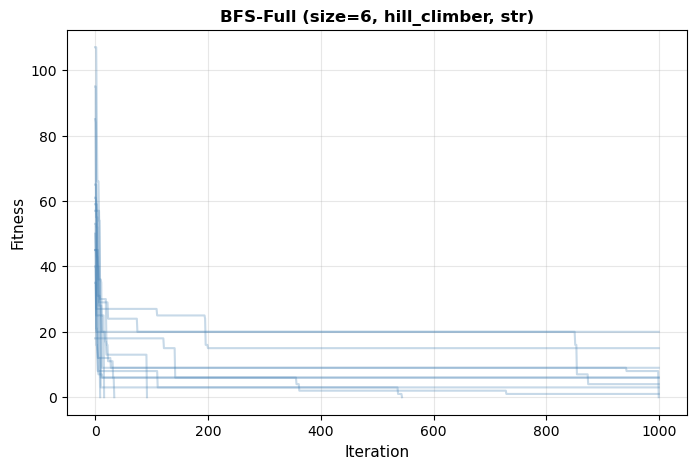

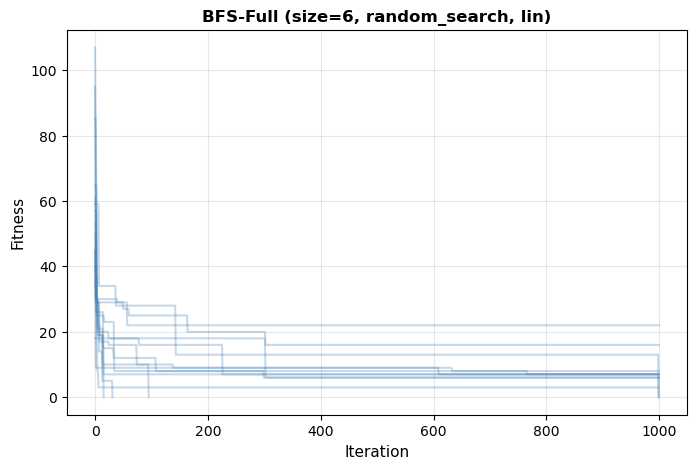

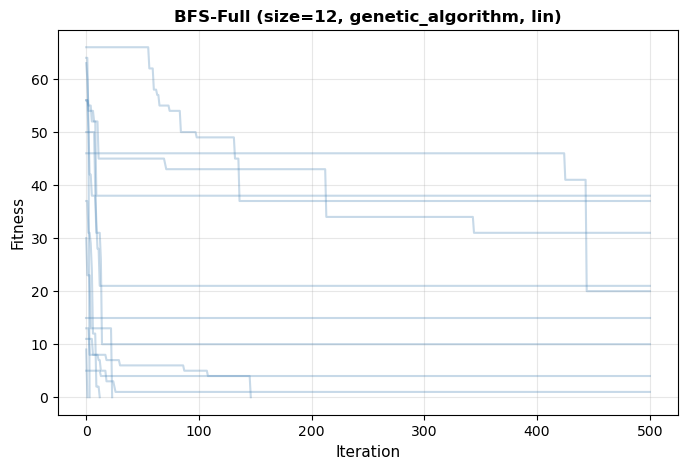

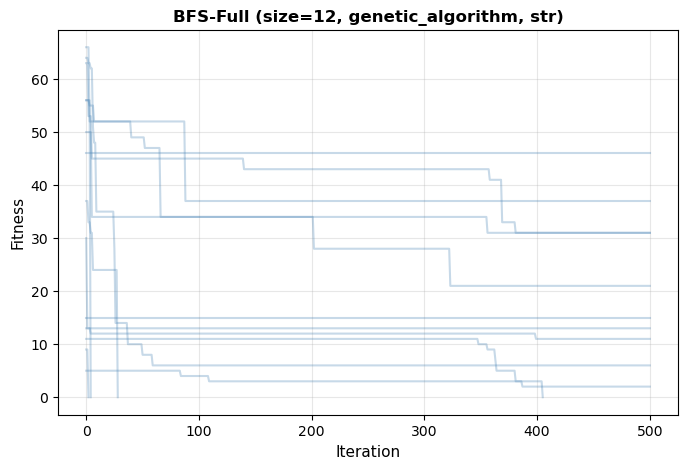

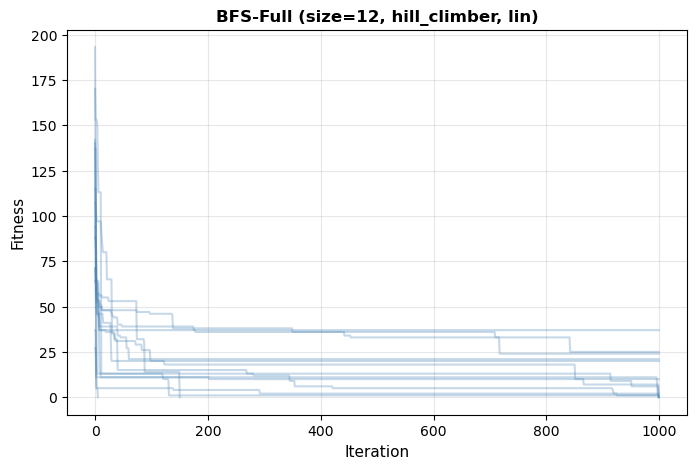

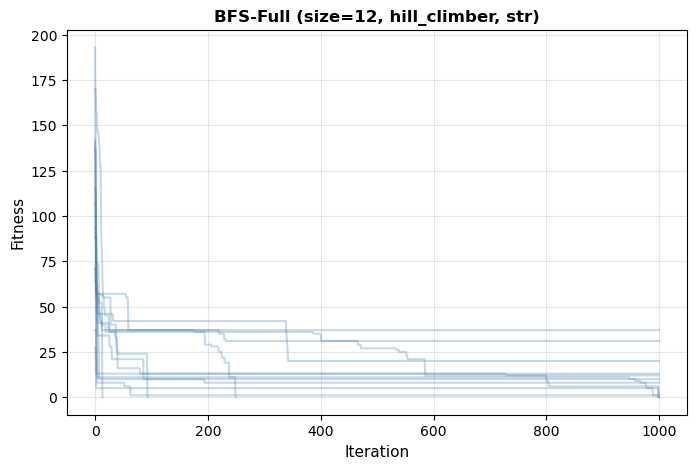

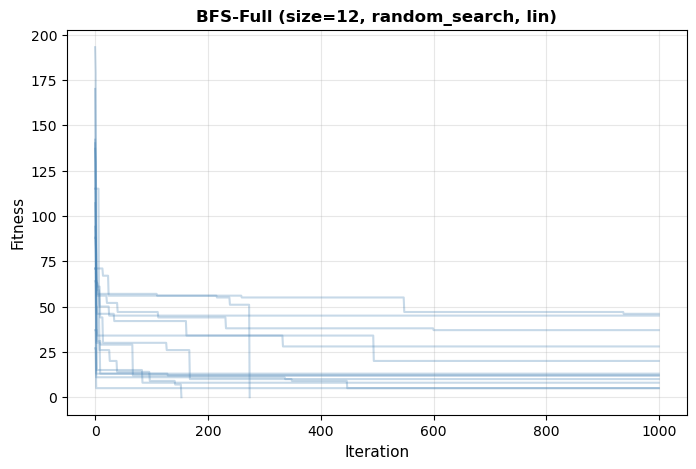

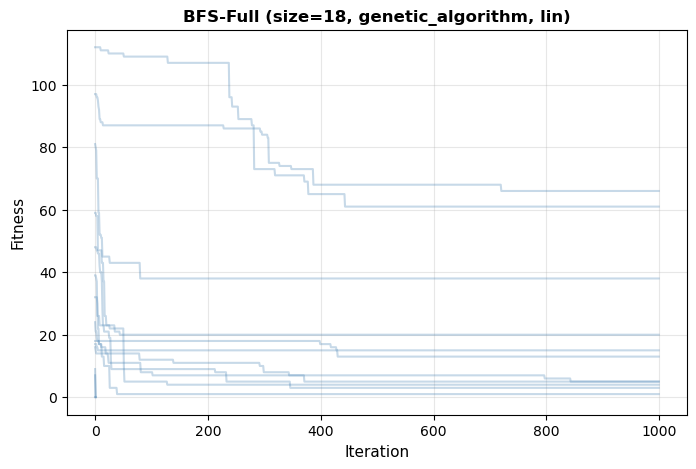

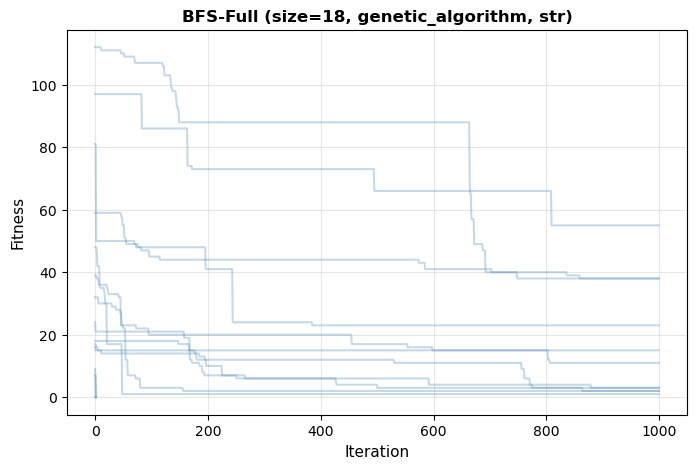

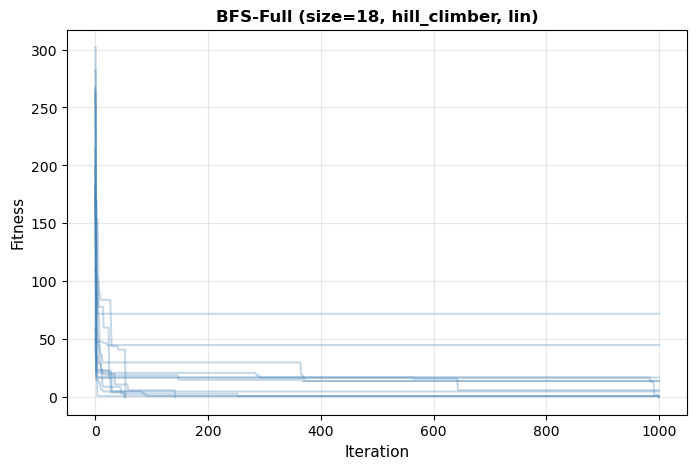

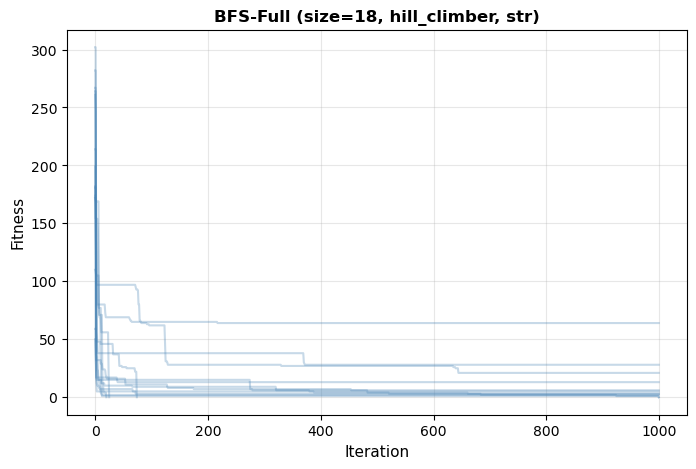

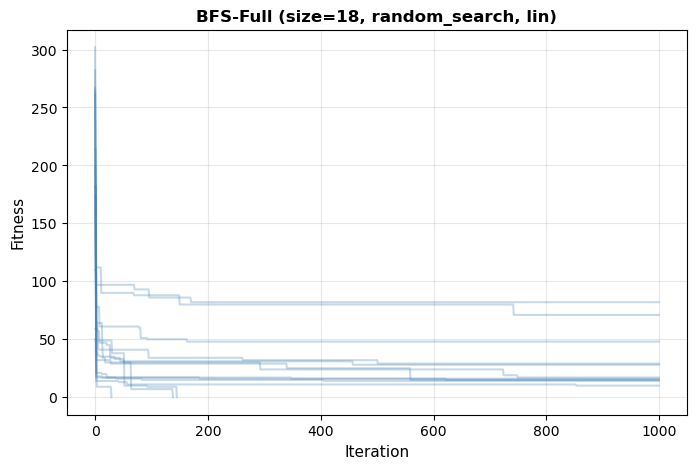

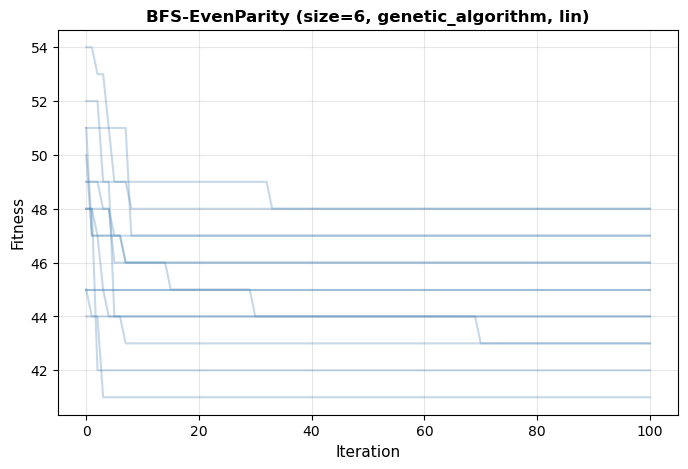

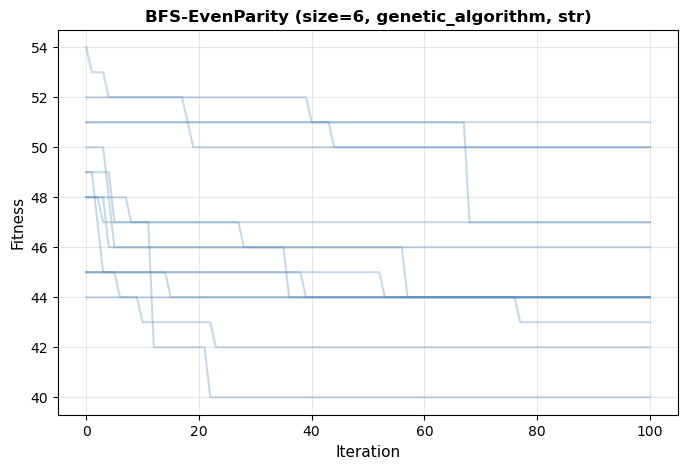

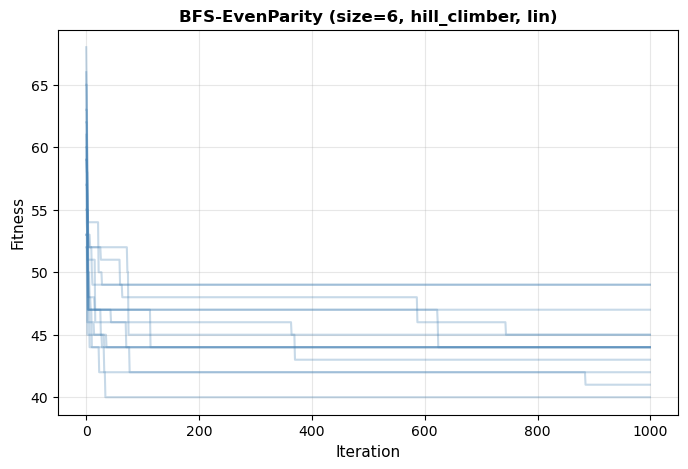

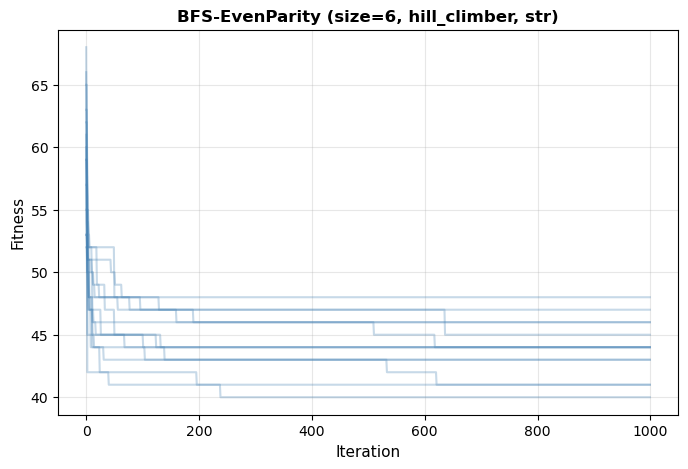

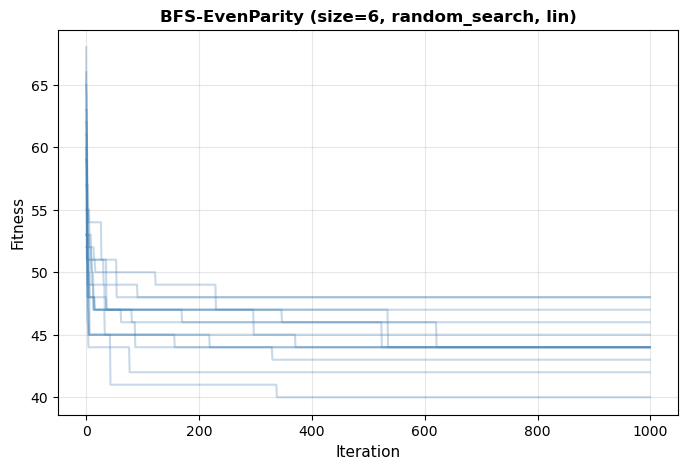

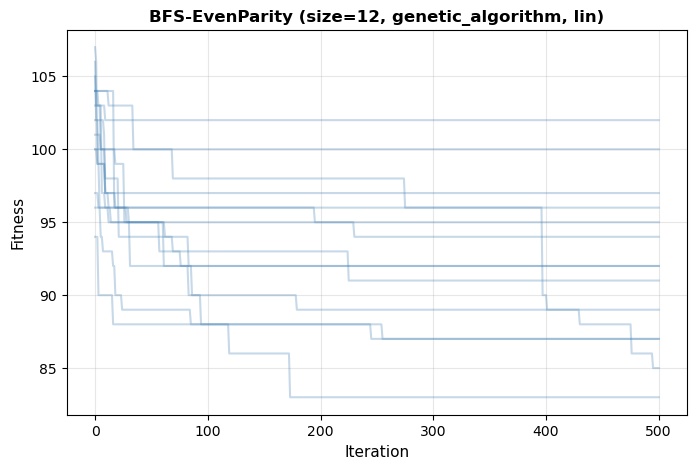

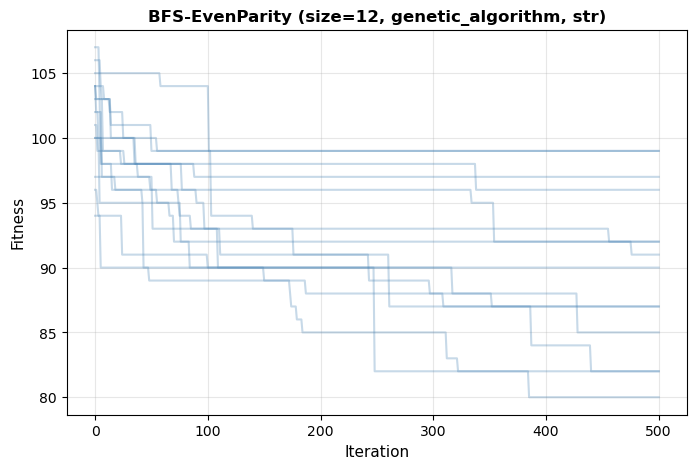

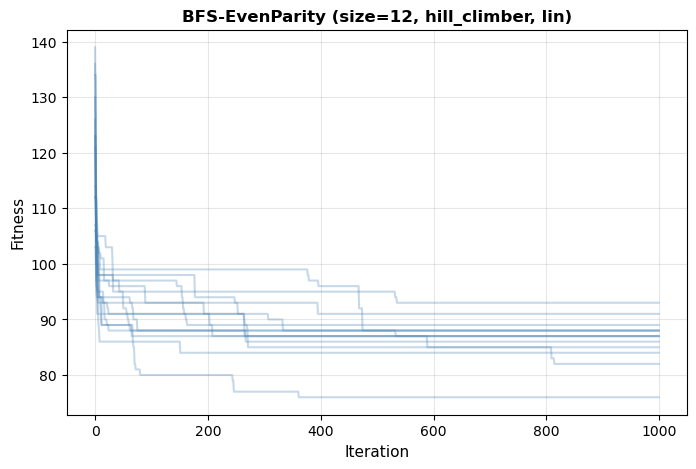

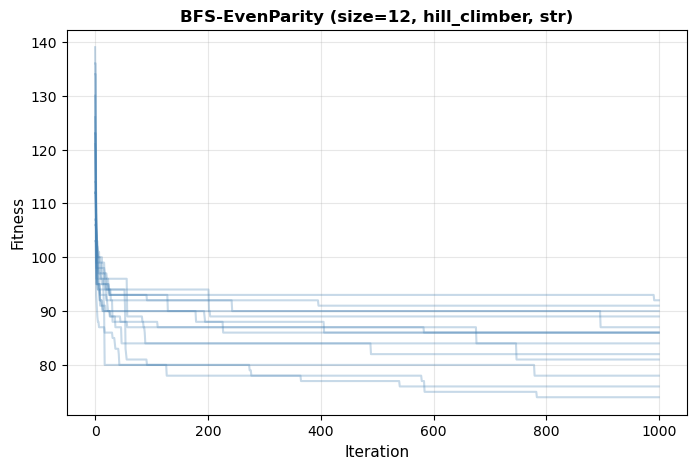

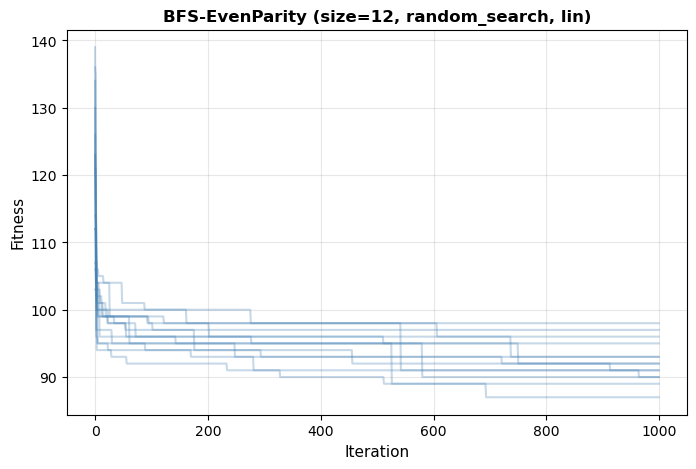

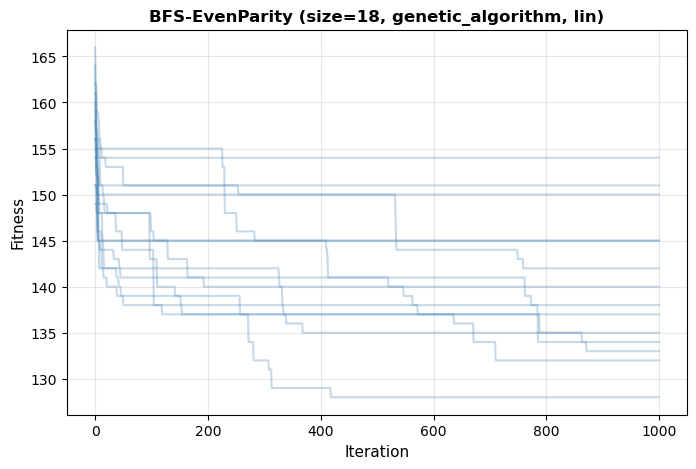

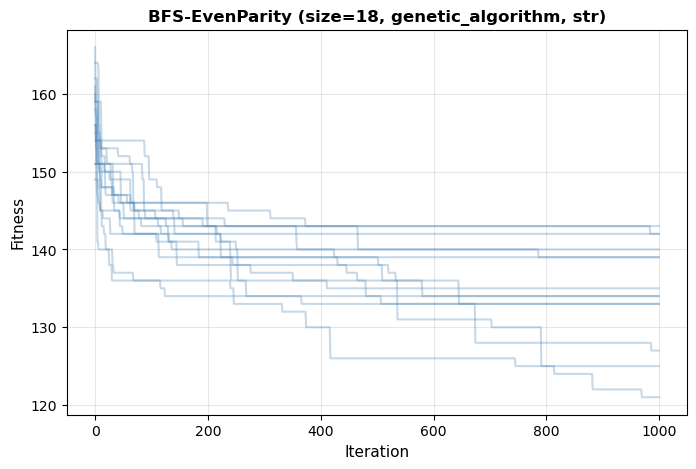

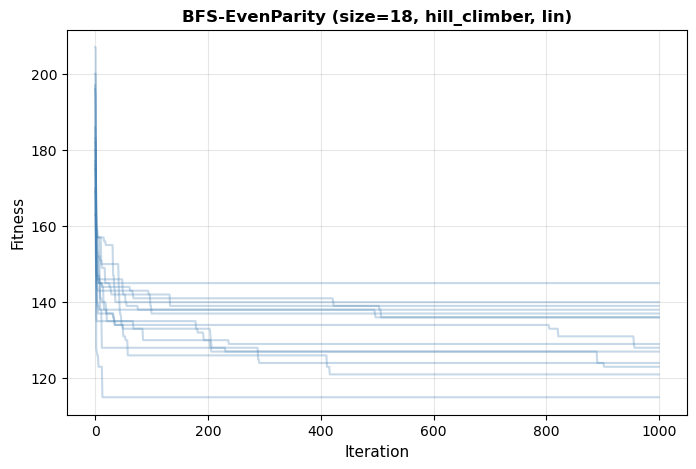

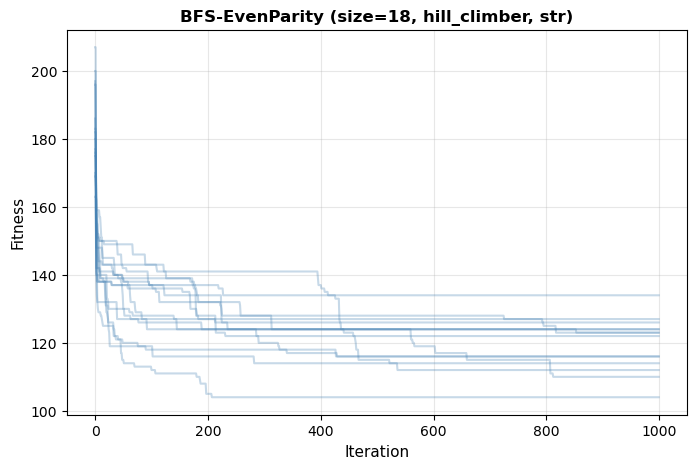

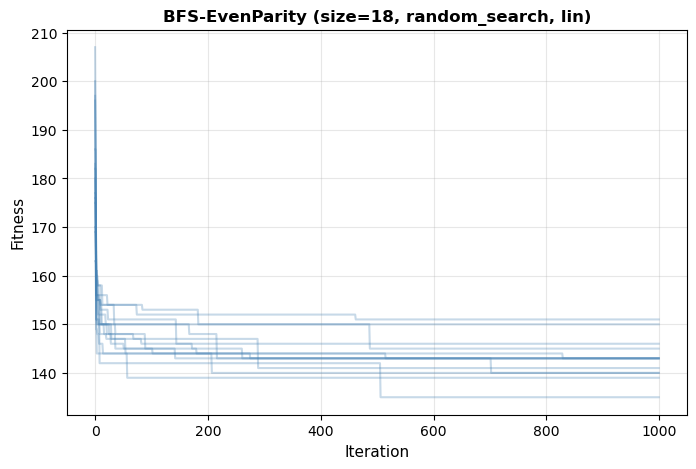

Created 60 fitness-vs-iteration plots


In [83]:
# Generate fitness-versus-iteration plots for each problem/size/solver/name_type combination
# Group by combination
grouped = history_df.groupby(['problem', 'size', 'solver', 'name_type'])

print(f"Generating {len(grouped)} fitness-vs-iteration plots...")

for (problem, size, solver, name_type), group in grouped:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    # Plot each rep as a faint line
    for _, row in group.iterrows():
        try:
            # Read history file
            hist = pd.read_csv(row['file'])
            
            # Plot with transparency - slightly thicker lines
            ax.plot(hist.index, hist['fitness'], alpha=0.3, linewidth=1.5, color='steelblue')
            
        except Exception as e:
            print(f"Error reading {row['file']}: {e}")
    
    # Formatting
    ax.set_xlabel('Iteration', fontsize=11)
    ax.set_ylabel('Fitness', fontsize=11)
    ax.set_title(f'{problem} (size={size}, {solver}, {name_type})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Save plot
    filename = f'outputs/fitness_history_{problem}_{size}_{solver}_{name_type}.pdf'
    plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()  # Display in notebook
    plt.close()

print(f"Created {len(grouped)} fitness-vs-iteration plots")

In [84]:
# Save solver summary table
solver_summary.to_csv('outputs/solver_summary_table.csv')
print("Solver summary table saved to outputs/solver_summary_table.csv")

# Export to LaTeX
latex_str = solver_summary.to_latex(float_format="%.3f", index=False)
with open('outputs/solver_summary_table.tex', 'w') as f:
    f.write(latex_str)
print("Solver summary table saved to outputs/solver_summary_table.tex")

Solver summary table saved to outputs/solver_summary_table.csv
Solver summary table saved to outputs/solver_summary_table.tex
